In [1]:
# Standard libraries
import os

# Data science & utilities
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    log_loss
)

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.transformers
from mlflow.tracking import MlflowClient

# PyTorch
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D,
    MaxPooling1D,
    Flatten,
    Embedding,
    SpatialDropout1D,
    LSTM,
    Bidirectional,
    Dropout,
    Dense
)
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, RobertaConfig

# Hugging Face datasets
from datasets import Dataset

# Gensim
from gensim.models import Word2Vec, FastText


e:\Formation - Copie\Projets\AnalyseSentiments\.env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the cleaned tweets dataset
data = pd.read_csv('data/tweets_cleaned.csv', encoding='latin-1')


In [3]:
# Display the first rows of the dataset
print(data.head())

# Show unique target values
print(data['target'].unique())

# Ensure target is in integer format
data['target'] = data['target'].astype(int)

# Display data types
print(data.dtypes)

# Count occurrences of each class in target
print(data['target'].value_counts())


   target                                               text  \
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1       0  is upset that he can't update his Facebook by ...   
2       0  @Kenichan I dived many times for the ball. Man...   
3       0    my whole body feels itchy and like its on fire    
4       0  @nationwideclass no, it's not behaving at all....   

                                        text_cleaned  \
0    - awww, that's a bummer.  you shoulda got da...   
1  is upset that he can't update his facebook by ...   
2   i dived many times for the ball. managed to s...   
3    my whole body feels itchy and like its on fire    
4   no, it's not behaving at all. i'm mad. why am...   

                                          text_tfidf  \
0  awww thats <OOV> bummer <OOV> shoulda got davi...   
1  <OOV> upset <OOV> <OOV> cant update <OOV> face...   
2  <OOV> dived many time <OOV> <OOV> ball managed...   
3  <OOV> whole body feel itchy <OOV> like <OOV> <...  

In [4]:
# Define the size of the new subset
subset_size = 10000

# Calculate the proportion of each class
target_counts = data['target'].value_counts(normalize=True)

# Determine the number of samples to draw per class
samples_per_class = (target_counts * subset_size).astype(int)

# Perform proportional stratified sampling
data = pd.concat([
    data[data['target'] == 0].sample(n=samples_per_class[0], random_state=42),
    data[data['target'] == 1].sample(n=samples_per_class[1], random_state=42)
])


In [5]:
data.head()

,target,text,text_cleaned,text_tfidf,text_lem_with_stopwords,text_lem_no_stopwords,text_stem_with_stopwords,text_stem_no_stopwords,text_bert
212188,0,@xnausikaax oh no! where did u order from? tha...,oh no! where did u order from? that's horrible,oh <OOV> <OOV> <OOV> u order <OOV> thats horrible,"['oh', '<OOV>', '<OOV>', '<OOV>', 'u', 'order'...","['oh', 'no', 'where', 'did', 'u', 'order', 'fr...","['oh', '<OOV>', '<OOV>', '<OOV>', 'u', 'order'...","['oh', 'u', 'order', 'that', 'horribl']",<oov> oh no! where did u order from? that's ho...
299036,0,A great hard training weekend is over. a coup...,a great hard training weekend is over. a coup...,<OOV> great hard training weekend <OOV> <OOV> ...,"['<OOV>', 'great', 'hard', 'training', 'weeken...","['a', 'great', 'hard', 'training', 'weekend', ...","['<OOV>', 'great', 'hard', 'train', 'weekend',...","['great', 'hard', 'train', 'weekend', 'coupl',...",a great hard training weekend is over. a coup...
475978,0,"Right, off to work Only 5 hours to go until I...","right, off to work only 5 hours to go until i...",right <OOV> <OOV> work <OOV> 5 hour <OOV> go <...,"['right', '<OOV>', '<OOV>', 'work', '<OOV>', '...","['right', 'off', 'to', 'work', 'only', '5', 'h...","['right', '<OOV>', '<OOV>', 'work', '<OOV>', '...","['right', 'work', '5', 'hour', 'go', 'im', 'fr...","right, off to work only 5 hours to go until i..."
588988,0,I am craving for japanese food,i am craving for japanese food,<OOV> <OOV> craving <OOV> japanese food,"['<OOV>', '<OOV>', 'craving', '<OOV>', 'japane...","['i', 'am', 'craving', 'for', 'japanese', 'food']","['<OOV>', '<OOV>', 'crave', '<OOV>', 'japanes'...","['crave', 'japanes', 'food']",i am craving for japanese food
138859,0,Jean Michel Jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow gotta work...,jean michel jarre concert tomorrow got ta work...,"['jean', 'michel', 'jarre', 'concert', 'tomorr...","['jean', 'michel', 'jarre', 'concert', 'tomorr...","['jean', 'michel', 'jarr', 'concert', 'tomorro...","['jean', 'michel', 'jarr', 'concert', 'tomorro...",jean michel jarre concert tomorrow gotta work...


# Decoupage des donnees (Train, Val, Test)

In [5]:


# Define dataset split proportions: 70% train, 15% validation, 15% test
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Separate features and target
X = data[
    ['text', 'text_cleaned', 'text_tfidf', 'text_lem_with_stopwords',
     'text_lem_no_stopwords', 'text_stem_with_stopwords',
     'text_stem_no_stopwords', 'text_bert']
]
y = data['target']

# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=(1 - train_size), stratify=y, random_state=42
)

# Second split: Validation (15%) and Test (15%) from Temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=test_size / (test_size + val_size),
    stratify=y_temp,
    random_state=42
)

# Display class distribution in each split
print("Dataset split summary:")
print(f"Train: {len(X_train)} samples\n{y_train.value_counts(normalize=True)}")
print(f"Validation: {len(X_val)} samples\n{y_val.value_counts(normalize=True)}")
print(f"Test: {len(X_test)} samples\n{y_test.value_counts(normalize=True)}")


Dataset split summary:
Train: 6999 samples
target
1    0.500071
0    0.499929
Name: proportion, dtype: float64
Validation: 1500 samples
target
1    0.5
0    0.5
Name: proportion, dtype: float64
Test: 1501 samples
target
0    0.500333
1    0.499667
Name: proportion, dtype: float64


# Fonction de visualisation des donnees

In [6]:
def log_metrics_to_mlflow(model_name, model, X_test, y_test, y_pred, y_prob):
    """
    Log extended evaluation metrics and incorrect predictions to MLflow.
    """
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    loss = log_loss(y_test, y_prob)
    baseline_acc = y_test.value_counts(normalize=True).max()
    confidence_std = np.std(y_prob)
    cm = confusion_matrix(y_test, y_pred)
    false_positives = cm[0][1]
    false_negatives = cm[1][0]

    # Identify incorrect predictions
    errors_df = X_test.copy()
    errors_df["true_label"] = y_test.values
    errors_df["predicted_label"] = y_pred
    errors_df["predicted_proba"] = y_prob
    errors_df = errors_df[errors_df["true_label"] != errors_df["predicted_label"]]
    errors_df.to_csv("errors.csv", index=False)

    mlflow.set_experiment(model_name)

    with mlflow.start_run(run_name=model_name):
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("log_loss", loss)
        mlflow.log_metric("baseline_accuracy", baseline_acc)
        mlflow.log_metric("confidence_std", confidence_std)
        mlflow.log_metric("false_positives", false_positives)
        mlflow.log_metric("false_negatives", false_negatives)

        # Log model
        mlflow.sklearn.log_model(model, "model")

        # Log errors
        mlflow.log_artifact("errors.csv", artifact_path="errors")

        # Log key examples as tags
        for i, row in errors_df.head(3).iterrows():
            mlflow.set_tag(f"error_{i}_text", row["text"])
            mlflow.set_tag(f"error_{i}_true", row["true_label"])
            mlflow.set_tag(f"error_{i}_pred", row["predicted_label"])

    print(
        f"Logged {model_name} — Accuracy: {accuracy:.3f}, F1: {f1:.3f}, ROC AUC: {roc_auc:.3f}"
    )


def plot_confusion_matrix(y_test, y_pred, model_name):
    """
    Display the confusion matrix using Seaborn heatmap.
    """
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap="Blues",
        xticklabels=["Negative", "Positive"],
        yticklabels=["Negative", "Positive"]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.tight_layout()
    plt.show()


def plot_roc_curve(y_test, y_prob, model_name):
    """
    Plot the ROC curve using Seaborn-style lineplot.
    """
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    sns.lineplot(x=fpr, y=tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_bar_chart(model_scores, title):
    labels, accuracy, f1, roc_auc = zip(*model_scores)
    df = pd.DataFrame({
        "Model": labels,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    })

    df_melt = df.melt(id_vars="Model", var_name="Metric", value_name="Score")

    ax = sns.barplot(x="Model", y="Score", hue="Metric", data=df_melt)
    ax.set_title(title)
    ax.set_xlabel("Model")
    ax.set_ylabel("Score")



def plot_boxplot(roc_auc_scores, title):
    """
    Display a boxplot of ROC AUC score distribution using Seaborn.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=roc_auc_scores)
    plt.title(title)
    plt.ylabel("ROC AUC Score")
    plt.tight_layout()
    plt.show()


# Dummy classifier

2025/04/18 18:01:44 INFO mlflow.tracking.fluent: Experiment with name 'DUMMY_CLASSIFIER' does not exist. Creating a new experiment.
2025/04/18 18:01:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged DUMMY_CLASSIFIER — Accuracy: 0.500, F1: 0.666, ROC AUC: 0.500


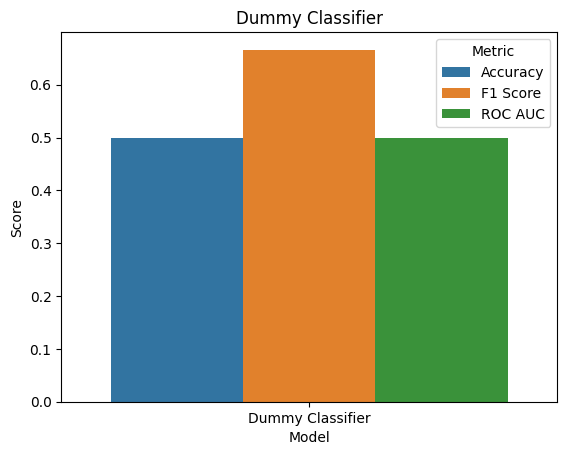

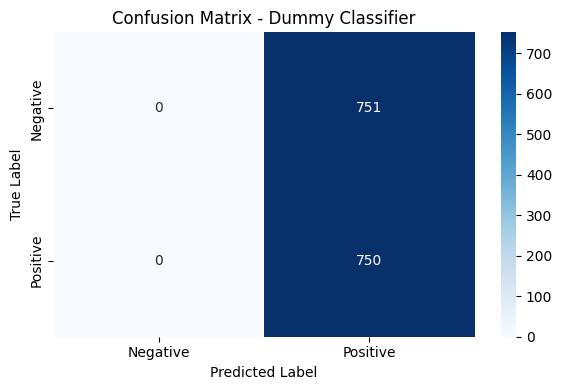

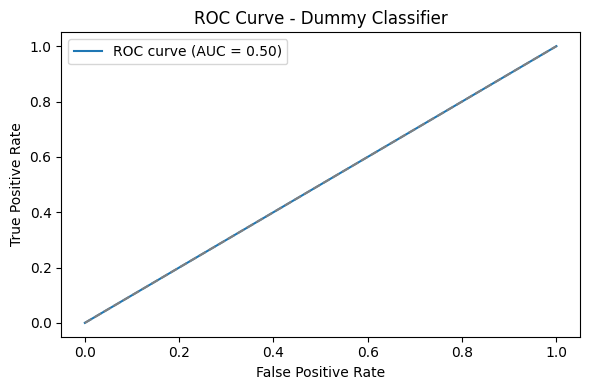

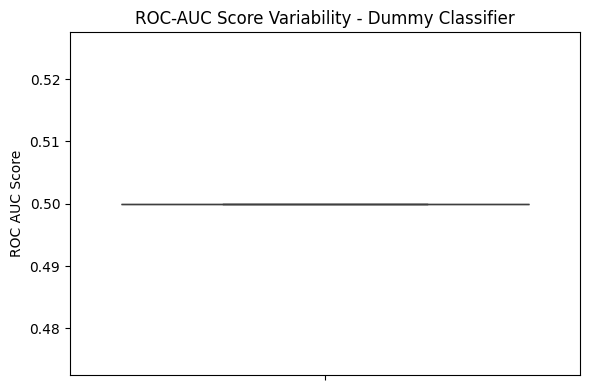

In [8]:
# Train Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train["text_cleaned"], y_train)

# Predict
y_pred = dummy_clf.predict(X_test["text_cleaned"])
y_prob = dummy_clf.predict_proba(X_test["text_cleaned"])[:, 1]

# Log metrics and errors with MLflow
log_metrics_to_mlflow(
    model_name="DUMMY_CLASSIFIER",
    model=dummy_clf,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    y_prob=y_prob
)

# Visualizations
model_scores = [("Dummy Classifier", accuracy_score(y_test, y_pred), f1_score(y_test, y_pred), roc_auc_score(y_test, y_prob))]
plot_bar_chart(model_scores, "Dummy Classifier")
plot_confusion_matrix(y_test, y_pred, "Dummy Classifier")
plot_roc_curve(y_test, y_prob, "Dummy Classifier")
plot_boxplot([roc_auc_score(y_test, y_prob)], "ROC-AUC Score Variability - Dummy Classifier")


#  Modèle Classique (TF-IDF + Régression Logistique)

In [9]:
# Replace NaN values with empty strings and ensure string type
X_train['text_tfidf'] = X_train['text_tfidf'].fillna("").astype(str)
X_val['text_tfidf'] = X_val['text_tfidf'].fillna("").astype(str)
X_test['text_tfidf'] = X_test['text_tfidf'].fillna("").astype(str)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform text data into TF-IDF vectors
X_train_tfidf = vectorizer.fit_transform(X_train['text_tfidf']).toarray()
X_val_tfidf = vectorizer.transform(X_val['text_tfidf']).toarray()
X_test_tfidf = vectorizer.transform(X_test['text_tfidf']).toarray()

# Convert labels to numpy arrays
y_train_np = y_train.to_numpy(dtype=int)
y_val_np = y_val.to_numpy(dtype=int)
y_test_np = y_test.to_numpy(dtype=int)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=5000, tfidf__ngram_range=(1, 2); total time=   0.1s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s
[CV] END logreg__C=0.01, tfidf__max_df=0.95, tfidf__max_features=10000, tfidf__ngram_range=(1, 1); total time=   0.0s


2025/04/18 18:02:14 INFO mlflow.tracking.fluent: Experiment with name 'TF-IDF_LOGREG' does not exist. Creating a new experiment.
2025/04/18 18:02:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged TF-IDF_LOGREG — Accuracy: 0.718, F1: 0.727, ROC AUC: 0.790


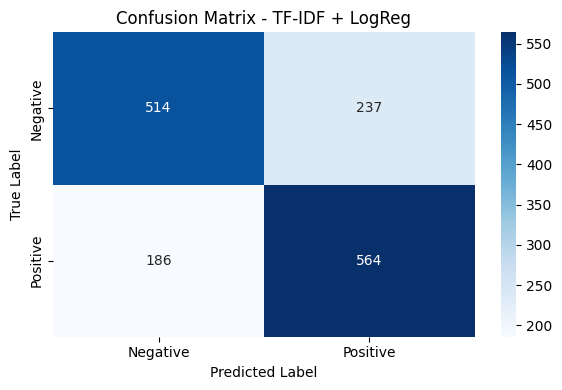

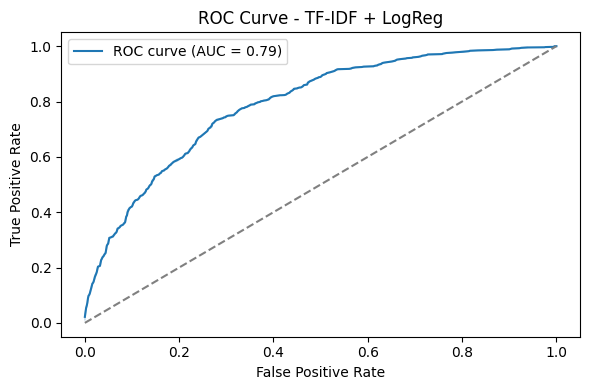

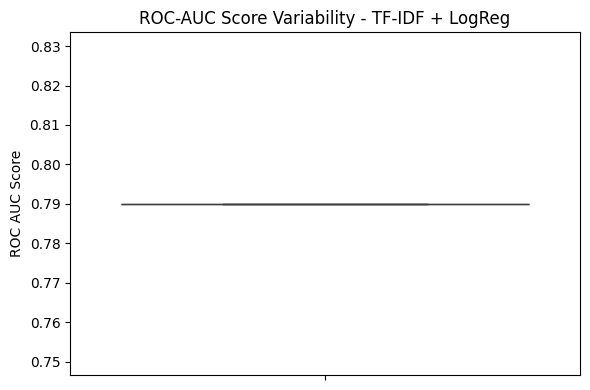

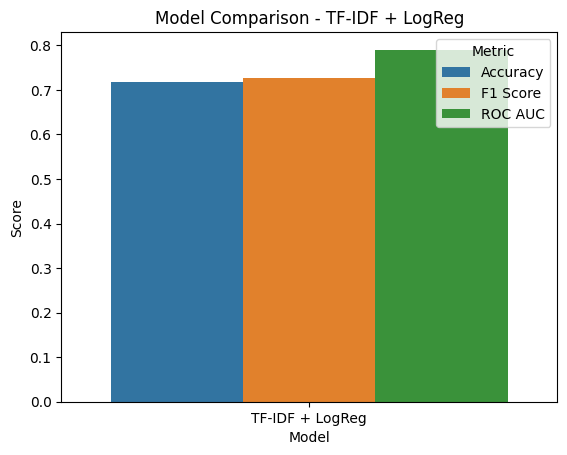

In [10]:
# Define pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', token_pattern=r'\b\w+\b')),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Define hyperparameter grid
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__max_df': [0.95, 0.90],
    'logreg__C': [0.01, 0.1, 1, 10]
}

# Ensure TF-IDF inputs are plain text
X_train_text = X_train["text_tfidf"].astype(str).tolist()
X_val_text = X_val["text_tfidf"].astype(str).tolist()
X_test_text = X_test["text_tfidf"].astype(str).tolist()

# Grid search with 3-fold CV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train_text, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predictions
y_val_pred = best_model.predict(X_val_text)
y_val_prob = best_model.predict_proba(X_val_text)[:, 1]
y_test_pred = best_model.predict(X_test_text)
y_test_prob = best_model.predict_proba(X_test_text)[:, 1]

# Log in MLflow with full metrics and examples
log_metrics_to_mlflow(
    model_name="TF-IDF_LOGREG",
    model=best_model,
    X_test=X_test,
    y_test=y_test,
    y_pred=y_test_pred,
    y_prob=y_test_prob
)

# Visualisations 100% Seaborn
plot_confusion_matrix(y_test, y_test_pred, "TF-IDF + LogReg")
plot_roc_curve(y_test, y_test_prob, "TF-IDF + LogReg")
plot_boxplot([roc_auc_score(y_test, y_test_prob)], "ROC-AUC Score Variability - TF-IDF + LogReg")

# Model comparison (add more models if needed)
model_scores = [
    ("TF-IDF + LogReg", accuracy_score(y_test, y_test_pred),
     f1_score(y_test, y_test_pred), roc_auc_score(y_test, y_test_prob))
]
plot_bar_chart(model_scores, "Model Comparison - TF-IDF + LogReg")


# Word Embeddings (Word2Vec / FastText) + LSTM

In [11]:
# Hyperparameters
EMBEDDING_DIM = 100  
MAX_SEQUENCE_LENGTH = 100  
BATCH_SIZE = 64
EPOCHS = 10

# Store embedding models
embedding_models = {}

# Text columns to use for training
text_columns = [
    "text_lem_with_stopwords", 
    "text_lem_no_stopwords", 
    "text_stem_with_stopwords", 
    "text_stem_no_stopwords"
]

# Train Word2Vec and FastText models
for col in text_columns:
    sentences = data[col].tolist()
    embedding_models[f"Word2Vec_{col}"] = Word2Vec(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4)
    embedding_models[f"FastText_{col}"] = FastText(sentences, vector_size=EMBEDDING_DIM, window=5, min_count=2, workers=4)

# Special token for OOV handling
special_token = "<OOV>"

# Mapping and matrices
word_indices = {}  
embedding_matrices = {}  

def build_embedding_matrix(model, word_index, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in model.wv:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix

# Build vocab and embeddings
for name, model in embedding_models.items():
    model.build_vocab([[special_token]], update=True)
    model.wv[special_token] = np.zeros((EMBEDDING_DIM,))
    word_indices[name] = {word: i + 1 for i, word in enumerate(model.wv.index_to_key)}
    embedding_matrices[name] = build_embedding_matrix(model, word_indices[name], EMBEDDING_DIM)

# Convert token lists to padded sequences
def tokens_to_sequences(tokens_list, word_index, max_length):
    sequences = [[word_index.get(word, word_index.get(special_token, 0)) for word in tokens] for tokens in tokens_list]
    return pad_sequences(sequences, maxlen=max_length, padding='post')

# Store model scores
model_scores = []

# Define LSTM model structure
def build_lstm_model(embedding_matrix):
    model = Sequential([
        Embedding(input_dim=embedding_matrix.shape[0], output_dim=EMBEDDING_DIM, 
                  weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False),
        SpatialDropout1D(0.3),
        Bidirectional(LSTM(128, return_sequences=True, activation='tanh', recurrent_activation='sigmoid')),
        Dropout(0.5),
        Bidirectional(LSTM(64, activation='tanh', recurrent_activation='sigmoid')),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
    return model




  Training LSTM model with Word2Vec_text_lem_with_stopwords...



2025/04/18 18:02:32 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Word2Vec_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 75s 635ms/step - loss: 0.6969 - accuracy: 0.5136 - val_loss: 0.6903 - val_accuracy: 0.5487
Epoch 2/10
110/110 [==============================] - 65s 592ms/step - loss: 0.6931 - accuracy: 0.5191 - val_loss: 0.6908 - val_accuracy: 0.5460
Epoch 3/10
110/110 [==============================] - 64s 585ms/step - loss: 0.6907 - accuracy: 0.5214 - val_loss: 0.6902 - val_accuracy: 0.5427
Epoch 4/10
110/110 [==============================] - 60s 543ms/step - loss: 0.6896 - accuracy: 0.5359 - val_loss: 0.6865 - val_accuracy: 0.5520
Epoch 5/10
110/110 [==============================] - 62s 566ms/step - loss: 0.6885 - accuracy: 0.5345 - val_loss: 0.6858 - val_accuracy: 0.5527
Epoch 6/10
110/110 [==============================] - 61s 554ms/step - loss: 0.6891 - accuracy: 0.5395 - val_loss: 0.6850 - val_accuracy: 0.5453
Epoch 7/10
110/110 [==============================] - 59s 541ms/step - loss: 0.6870 - accuracy: 0.5406 - val_loss: 0.6899 - val_ac

2025/04/18 18:13:16 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpmuq_oomf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpmuq_oomf\model\data\model\assets
2025/04/18 18:13:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


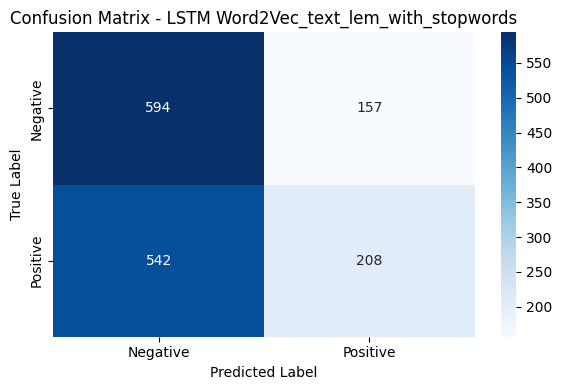

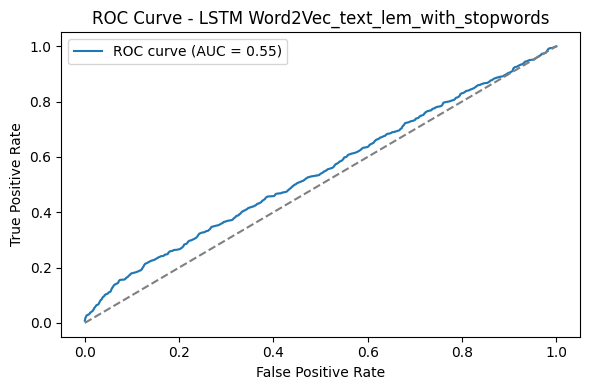

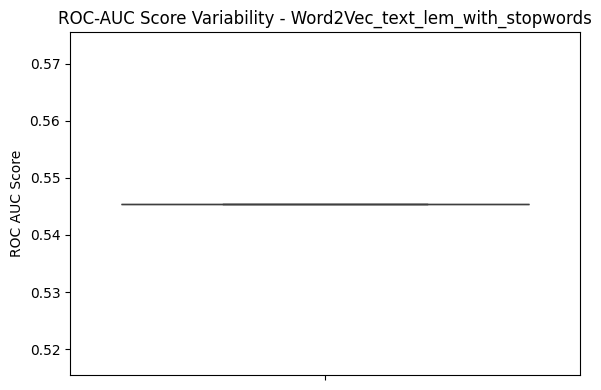


  Training LSTM model with FastText_text_lem_with_stopwords...



2025/04/18 18:13:55 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_FastText_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 36s 289ms/step - loss: 0.6964 - accuracy: 0.5128 - val_loss: 0.6905 - val_accuracy: 0.5373
Epoch 2/10
110/110 [==============================] - 33s 302ms/step - loss: 0.6924 - accuracy: 0.5241 - val_loss: 0.6903 - val_accuracy: 0.5147
Epoch 3/10
110/110 [==============================] - 55s 498ms/step - loss: 0.6899 - accuracy: 0.5291 - val_loss: 0.6861 - val_accuracy: 0.5507
Epoch 4/10
110/110 [==============================] - 57s 516ms/step - loss: 0.6915 - accuracy: 0.5246 - val_loss: 0.6848 - val_accuracy: 0.5493
Epoch 5/10
110/110 [==============================] - 57s 516ms/step - loss: 0.6892 - accuracy: 0.5359 - val_loss: 0.6871 - val_accuracy: 0.5653
Epoch 6/10
110/110 [==============================] - 57s 518ms/step - loss: 0.6876 - accuracy: 0.5446 - val_loss: 0.6833 - val_accuracy: 0.5507
Epoch 7/10
110/110 [==============================] - 57s 515ms/step - loss: 0.6859 - accuracy: 0.5461 - val_loss: 0.6839 - val_ac

2025/04/18 18:22:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpjcncqdq4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpjcncqdq4\model\data\model\assets
2025/04/18 18:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


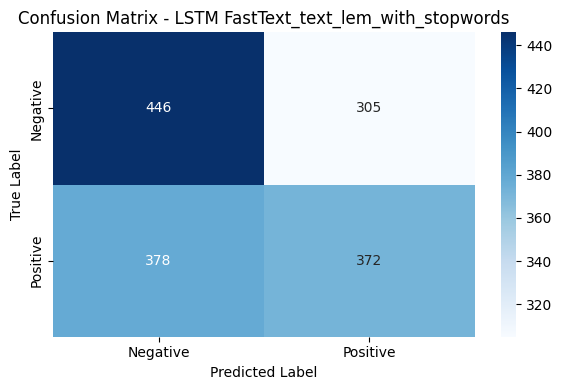

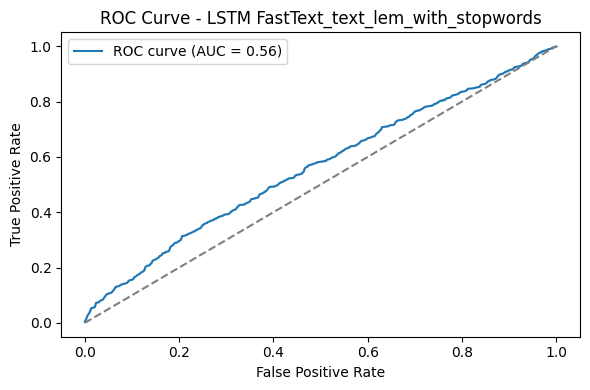

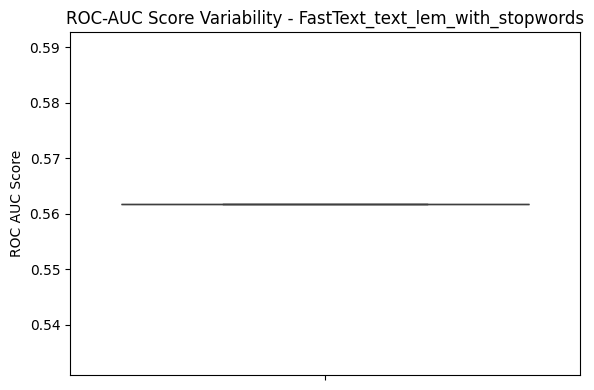


  Training LSTM model with Word2Vec_text_lem_no_stopwords...



2025/04/18 18:23:14 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Word2Vec_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 232s 2s/step - loss: 0.6967 - accuracy: 0.5098 - val_loss: 0.6918 - val_accuracy: 0.5300
Epoch 2/10
110/110 [==============================] - 211s 2s/step - loss: 0.6951 - accuracy: 0.5026 - val_loss: 0.6911 - val_accuracy: 0.5353
Epoch 3/10
110/110 [==============================] - 213s 2s/step - loss: 0.6932 - accuracy: 0.5181 - val_loss: 0.6918 - val_accuracy: 0.5233
Epoch 4/10
110/110 [==============================] - 214s 2s/step - loss: 0.6935 - accuracy: 0.5169 - val_loss: 0.6898 - val_accuracy: 0.5380
Epoch 5/10
110/110 [==============================] - 217s 2s/step - loss: 0.6926 - accuracy: 0.5196 - val_loss: 0.6886 - val_accuracy: 0.5407
Epoch 6/10
110/110 [==============================] - 208s 2s/step - loss: 0.6898 - accuracy: 0.5268 - val_loss: 0.6854 - val_accuracy: 0.5573
Epoch 7/10
110/110 [==============================] - 207s 2s/step - loss: 0.6893 - accuracy: 0.5389 - val_loss: 0.6861 - val_accuracy: 0.5393

2025/04/18 18:58:49 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpplian5ai\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpplian5ai\model\data\model\assets
2025/04/18 18:59:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


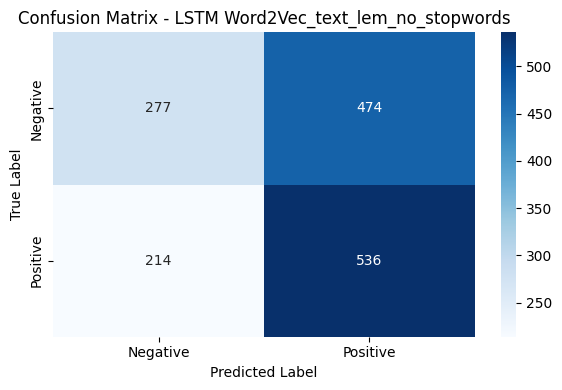

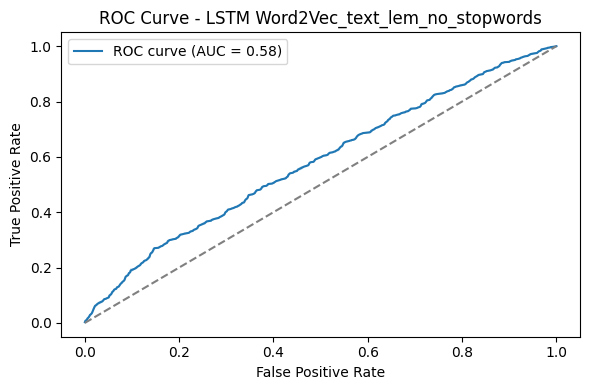

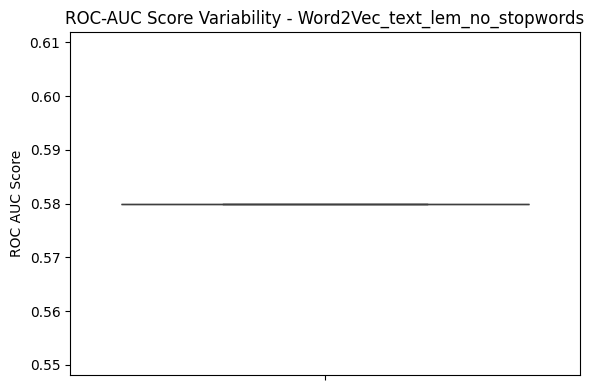


  Training LSTM model with FastText_text_lem_no_stopwords...



2025/04/18 18:59:26 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_FastText_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 203s 2s/step - loss: 0.6974 - accuracy: 0.5136 - val_loss: 0.6922 - val_accuracy: 0.5267
Epoch 2/10
110/110 [==============================] - 190s 2s/step - loss: 0.6936 - accuracy: 0.5109 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 3/10
110/110 [==============================] - 191s 2s/step - loss: 0.6949 - accuracy: 0.5104 - val_loss: 0.6916 - val_accuracy: 0.5320
Epoch 4/10
110/110 [==============================] - 191s 2s/step - loss: 0.6932 - accuracy: 0.5168 - val_loss: 0.6907 - val_accuracy: 0.5347
Epoch 5/10
110/110 [==============================] - 191s 2s/step - loss: 0.6932 - accuracy: 0.5145 - val_loss: 0.6903 - val_accuracy: 0.5327
Epoch 6/10
110/110 [==============================] - 192s 2s/step - loss: 0.6926 - accuracy: 0.5122 - val_loss: 0.6902 - val_accuracy: 0.5547
Epoch 7/10
110/110 [==============================] - 191s 2s/step - loss: 0.6904 - accuracy: 0.5321 - val_loss: 0.6880 - val_accuracy: 0.5373

2025/04/18 19:31:44 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpywfhquvg\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpywfhquvg\model\data\model\assets
2025/04/18 19:32:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


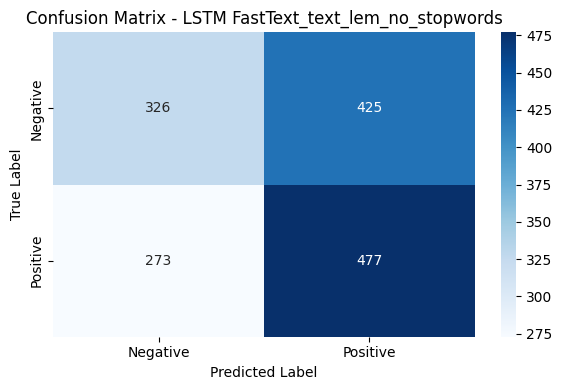

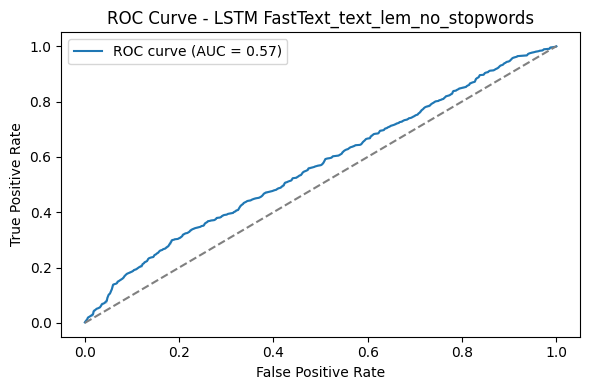

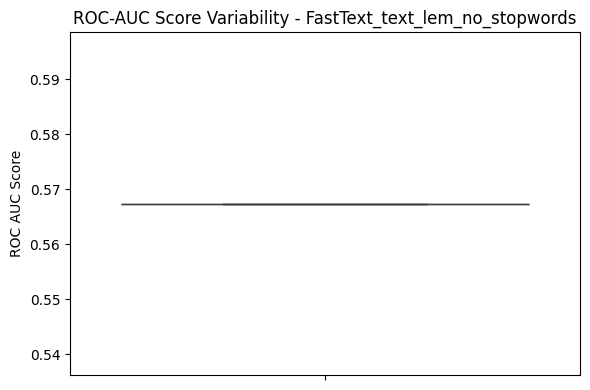


  Training LSTM model with Word2Vec_text_stem_with_stopwords...



2025/04/18 19:32:23 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Word2Vec_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 274s 2s/step - loss: 0.6946 - accuracy: 0.5166 - val_loss: 0.6909 - val_accuracy: 0.5333
Epoch 2/10
110/110 [==============================] - 260s 2s/step - loss: 0.6923 - accuracy: 0.5185 - val_loss: 0.6937 - val_accuracy: 0.5347
Epoch 3/10
110/110 [==============================] - 263s 2s/step - loss: 0.6932 - accuracy: 0.5211 - val_loss: 0.6865 - val_accuracy: 0.5407
Epoch 4/10
110/110 [==============================] - 263s 2s/step - loss: 0.6891 - accuracy: 0.5336 - val_loss: 0.6883 - val_accuracy: 0.5460
Epoch 5/10
110/110 [==============================] - 263s 2s/step - loss: 0.6911 - accuracy: 0.5201 - val_loss: 0.6893 - val_accuracy: 0.5580
Epoch 6/10
110/110 [==============================] - 262s 2s/step - loss: 0.6910 - accuracy: 0.5269 - val_loss: 0.6856 - val_accuracy: 0.5553
Epoch 7/10
110/110 [==============================] - 263s 2s/step - loss: 0.6889 - accuracy: 0.5358 - val_loss: 0.6853 - val_accuracy: 0.5607

2025/04/18 20:16:33 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpfe7p_6ce\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpfe7p_6ce\model\data\model\assets
2025/04/18 20:17:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


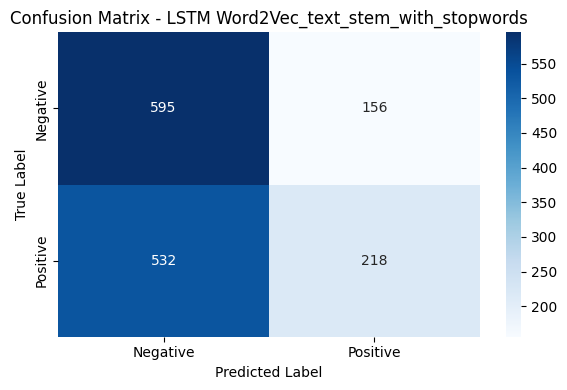

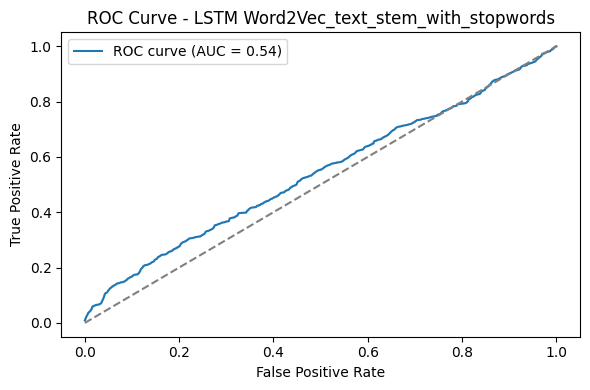

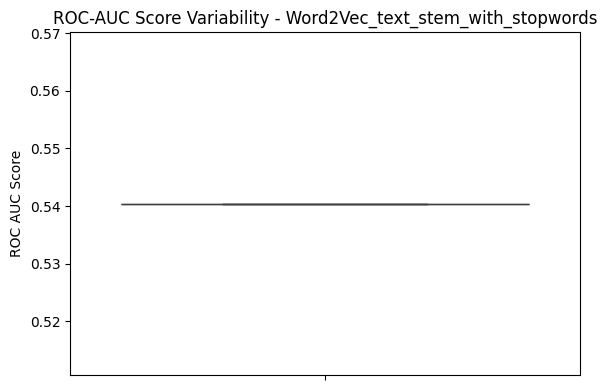


  Training LSTM model with FastText_text_stem_with_stopwords...



2025/04/18 20:17:12 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_FastText_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 330s 3s/step - loss: 0.6972 - accuracy: 0.5056 - val_loss: 0.6978 - val_accuracy: 0.5367
Epoch 2/10
110/110 [==============================] - 303s 3s/step - loss: 0.6942 - accuracy: 0.5241 - val_loss: 0.6916 - val_accuracy: 0.5193
Epoch 3/10
110/110 [==============================] - 304s 3s/step - loss: 0.6915 - accuracy: 0.5235 - val_loss: 0.6873 - val_accuracy: 0.5487
Epoch 4/10
110/110 [==============================] - 304s 3s/step - loss: 0.6897 - accuracy: 0.5365 - val_loss: 0.6865 - val_accuracy: 0.5493
Epoch 5/10
110/110 [==============================] - 303s 3s/step - loss: 0.6898 - accuracy: 0.5305 - val_loss: 0.6880 - val_accuracy: 0.5387
Epoch 6/10
110/110 [==============================] - 305s 3s/step - loss: 0.6886 - accuracy: 0.5346 - val_loss: 0.6864 - val_accuracy: 0.5593
Epoch 7/10
110/110 [==============================] - 304s 3s/step - loss: 0.6871 - accuracy: 0.5391 - val_loss: 0.6873 - val_accuracy: 0.5513

2025/04/18 21:08:35 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpcuibjvei\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpcuibjvei\model\data\model\assets
2025/04/18 21:09:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


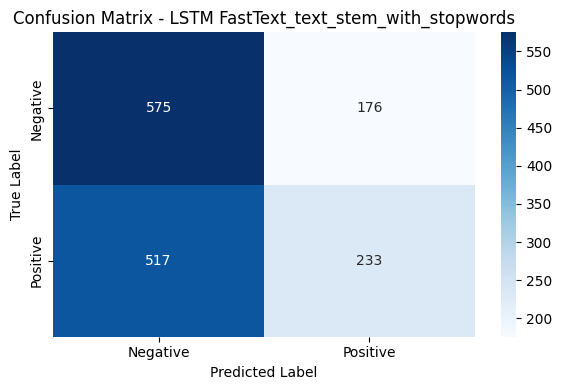

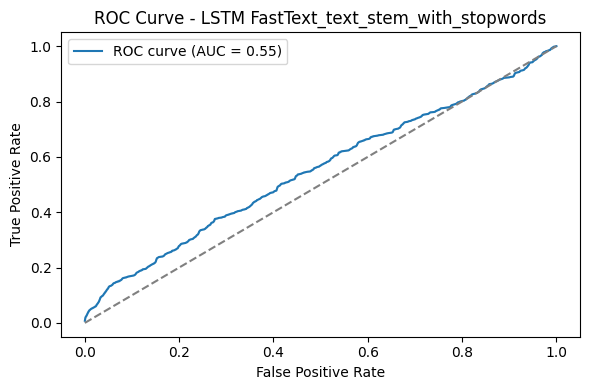

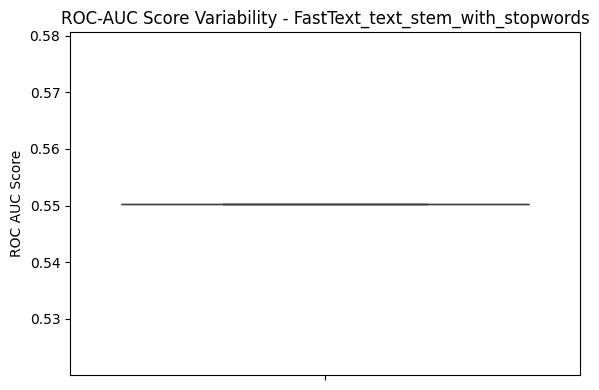


  Training LSTM model with Word2Vec_text_stem_no_stopwords...



2025/04/18 21:09:12 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_Word2Vec_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 385s 3s/step - loss: 0.6974 - accuracy: 0.5006 - val_loss: 0.6963 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 377s 3s/step - loss: 0.6949 - accuracy: 0.5065 - val_loss: 0.6930 - val_accuracy: 0.4987
Epoch 3/10
110/110 [==============================] - 378s 3s/step - loss: 0.6952 - accuracy: 0.5016 - val_loss: 0.6965 - val_accuracy: 0.5000
Epoch 4/10
110/110 [==============================] - 379s 3s/step - loss: 0.6934 - accuracy: 0.5138 - val_loss: 0.6927 - val_accuracy: 0.5093
Epoch 5/10
110/110 [==============================] - 378s 3s/step - loss: 0.6936 - accuracy: 0.5072 - val_loss: 0.6928 - val_accuracy: 0.4987
Epoch 6/10
110/110 [==============================] - 382s 3s/step - loss: 0.6932 - accuracy: 0.5044 - val_loss: 0.6924 - val_accuracy: 0.5127
Epoch 7/10
110/110 [==============================] - 374s 3s/step - loss: 0.6937 - accuracy: 0.5106 - val_loss: 0.6929 - val_accuracy: 0.5087

2025/04/18 22:12:37 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpn4d4w9p8\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpn4d4w9p8\model\data\model\assets
2025/04/18 22:13:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


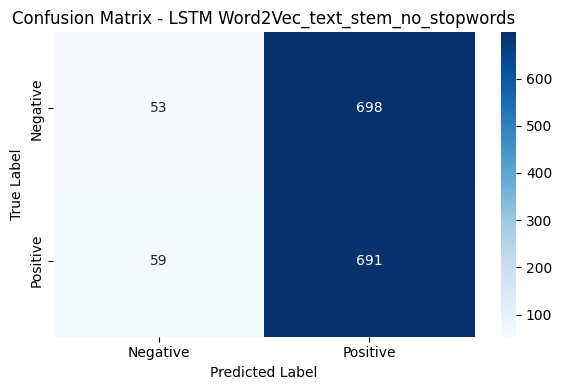

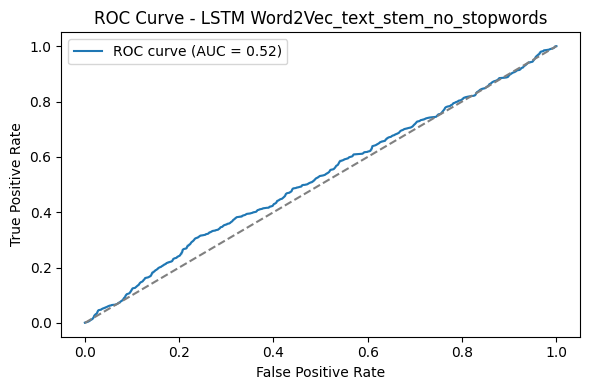

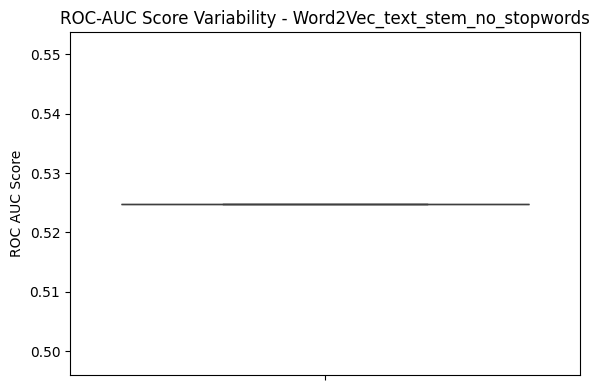


  Training LSTM model with FastText_text_stem_no_stopwords...



2025/04/18 22:13:15 INFO mlflow.tracking.fluent: Experiment with name 'LSTM_FastText_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 410s 4s/step - loss: 0.6971 - accuracy: 0.5032 - val_loss: 0.6920 - val_accuracy: 0.5187
Epoch 2/10
110/110 [==============================] - 402s 4s/step - loss: 0.6940 - accuracy: 0.5128 - val_loss: 0.6925 - val_accuracy: 0.5433
Epoch 3/10
110/110 [==============================] - 404s 4s/step - loss: 0.6958 - accuracy: 0.5026 - val_loss: 0.6926 - val_accuracy: 0.5080
Epoch 4/10
110/110 [==============================] - 405s 4s/step - loss: 0.6937 - accuracy: 0.5108 - val_loss: 0.6925 - val_accuracy: 0.5140
Epoch 5/10
110/110 [==============================] - 408s 4s/step - loss: 0.6941 - accuracy: 0.5046 - val_loss: 0.6914 - val_accuracy: 0.5247
Epoch 6/10
110/110 [==============================] - 406s 4s/step - loss: 0.6926 - accuracy: 0.5132 - val_loss: 0.6951 - val_accuracy: 0.4993
Epoch 7/10
110/110 [==============================] - 405s 4s/step - loss: 0.6926 - accuracy: 0.5231 - val_loss: 0.6949 - val_accuracy: 0.5020

2025/04/18 23:22:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpod8h8wxz\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpod8h8wxz\model\data\model\assets
2025/04/18 23:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


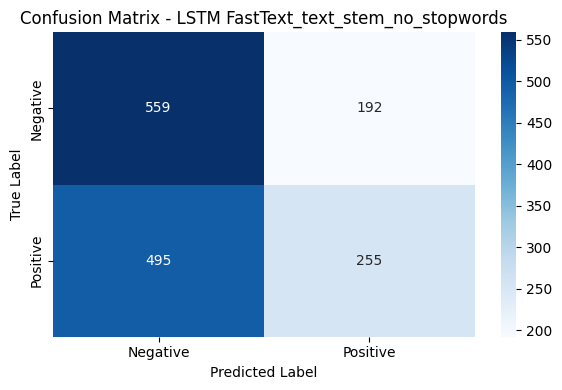

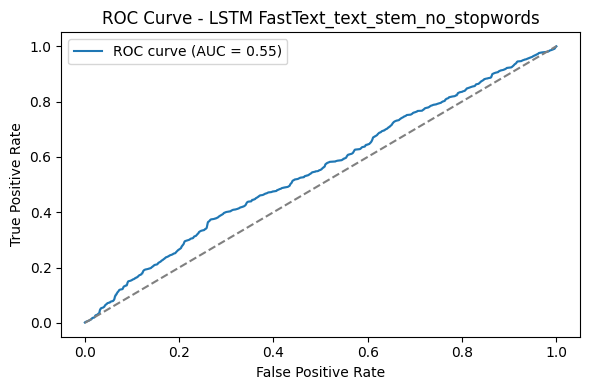

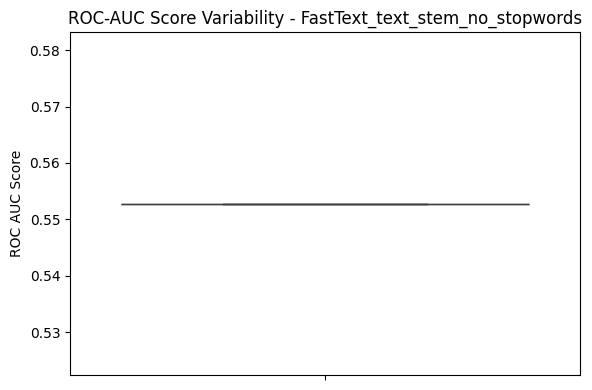

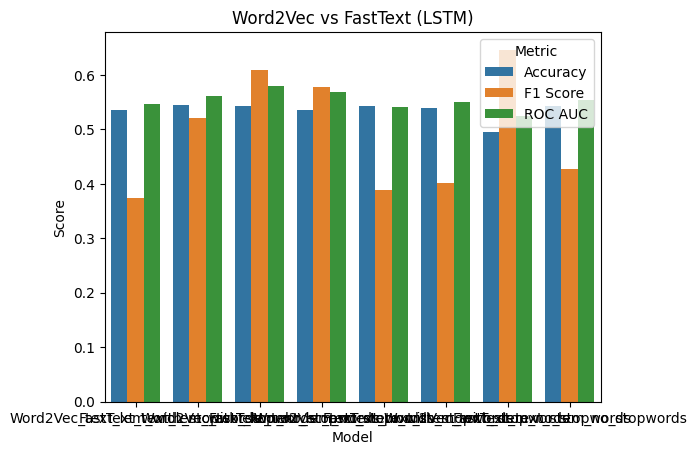

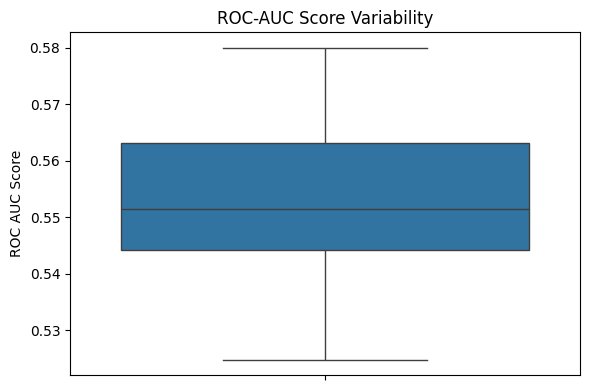

In [12]:
model_scores = []

for embedding_name in embedding_models.keys():
    print(f"\n  Training LSTM model with {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]

    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)

    model = build_lstm_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"LSTM_{embedding_name}")
    with mlflow.start_run(run_name=f"LSTM_{embedding_name}"):

        history = model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
        )

        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        loss = log_loss(y_test, y_pred_prob)
        baseline_acc = y_test.value_counts(normalize=True).max()
        confidence_std = np.std(y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        false_positives = cm[0][1]
        false_negatives = cm[1][0]

        # MLflow logging
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("log_loss", loss)
        mlflow.log_metric("baseline_accuracy", baseline_acc)
        mlflow.log_metric("confidence_std", confidence_std)
        mlflow.log_metric("false_positives", false_positives)
        mlflow.log_metric("false_negatives", false_negatives)
        mlflow.keras.log_model(model, f"lstm_{embedding_name}_model")

        # Errors
        errors_df = X_test.copy()
        errors_df["true_label"] = y_test.values
        errors_df["predicted_label"] = y_pred
        errors_df["predicted_proba"] = y_pred_prob
        errors_df = errors_df[errors_df["true_label"] != errors_df["predicted_label"]]
        error_filename = f"errors_{embedding_name}.csv"
        errors_df.to_csv(error_filename, index=False)
        mlflow.log_artifact(error_filename, artifact_path="errors")

        for i, row in errors_df.head(3).iterrows():
            mlflow.set_tag(f"error_{i}_text", row["text"])
            mlflow.set_tag(f"error_{i}_true", row["true_label"])
            mlflow.set_tag(f"error_{i}_pred", row["predicted_label"])

        # Visuals
        plot_confusion_matrix(y_test, y_pred, f"LSTM {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"LSTM {embedding_name}")
        plot_boxplot([roc_auc], f"ROC-AUC Score Variability - {embedding_name}")

        model_scores.append((embedding_name, accuracy, f1, roc_auc))

mlflow.end_run()

# Global comparisons
plot_bar_chart(model_scores, "Word2Vec vs FastText (LSTM)")
roc_auc_values = [score[3] for score in model_scores]
plot_boxplot(roc_auc_values, "ROC-AUC Score Variability")



# CNN avec Word Embeddings


Training CNN model with Word2Vec_text_lem_with_stopwords...



2025/04/18 23:23:16 INFO mlflow.tracking.fluent: Experiment with name 'CNN_Word2Vec_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 12s 104ms/step - loss: 0.7145 - accuracy: 0.5058 - val_loss: 0.6914 - val_accuracy: 0.5413
Epoch 2/10
110/110 [==============================] - 11s 102ms/step - loss: 0.6905 - accuracy: 0.5225 - val_loss: 0.6857 - val_accuracy: 0.5380
Epoch 3/10
110/110 [==============================] - 11s 102ms/step - loss: 0.6831 - accuracy: 0.5388 - val_loss: 0.6830 - val_accuracy: 0.5680
Epoch 4/10
110/110 [==============================] - 11s 103ms/step - loss: 0.6758 - accuracy: 0.5661 - val_loss: 0.6756 - val_accuracy: 0.5873
Epoch 5/10
110/110 [==============================] - 11s 103ms/step - loss: 0.6610 - accuracy: 0.5925 - val_loss: 0.6717 - val_accuracy: 0.5727
Epoch 6/10
110/110 [==============================] - 11s 103ms/step - loss: 0.6436 - accuracy: 0.6171 - val_loss: 0.6695 - val_accuracy: 0.5987
Epoch 7/10
110/110 [==============================] - 11s 104ms/step - loss: 0.6188 - accuracy: 0.6521 - val_loss: 0.6698 - val_ac

2025/04/18 23:25:11 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp7xd30xnw\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp7xd30xnw\model\data\model\assets
2025/04/18 23:25:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


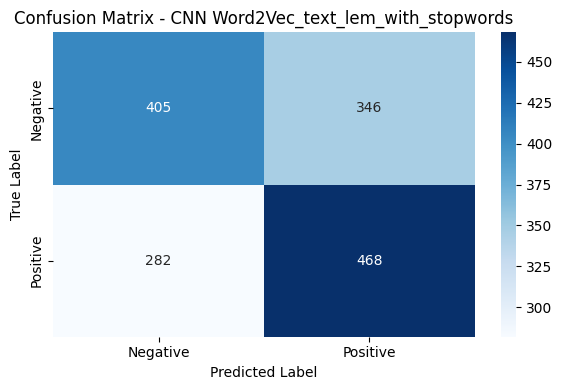

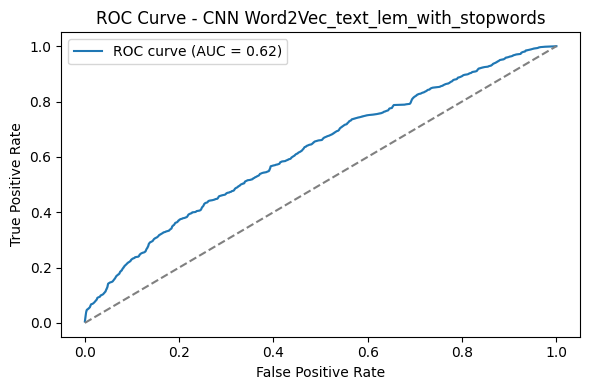

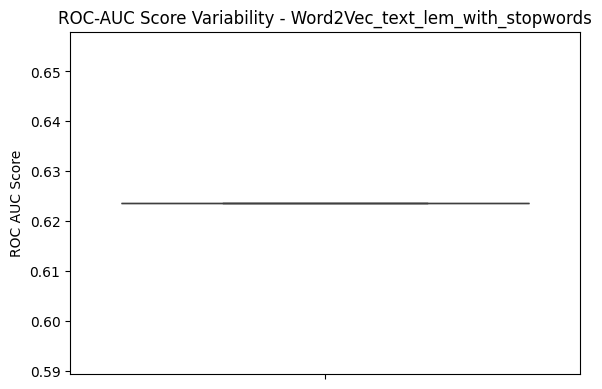


Training CNN model with FastText_text_lem_with_stopwords...



2025/04/18 23:25:27 INFO mlflow.tracking.fluent: Experiment with name 'CNN_FastText_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 12s 98ms/step - loss: 0.7000 - accuracy: 0.5079 - val_loss: 0.6911 - val_accuracy: 0.5493
Epoch 2/10
110/110 [==============================] - 11s 96ms/step - loss: 0.6896 - accuracy: 0.5294 - val_loss: 0.6877 - val_accuracy: 0.5533
Epoch 3/10
110/110 [==============================] - 11s 97ms/step - loss: 0.6855 - accuracy: 0.5409 - val_loss: 0.6828 - val_accuracy: 0.5480
Epoch 4/10
110/110 [==============================] - 11s 96ms/step - loss: 0.6778 - accuracy: 0.5531 - val_loss: 0.6789 - val_accuracy: 0.5527
Epoch 5/10
110/110 [==============================] - 11s 96ms/step - loss: 0.6676 - accuracy: 0.5751 - val_loss: 0.6755 - val_accuracy: 0.5793
Epoch 6/10
110/110 [==============================] - 11s 96ms/step - loss: 0.6507 - accuracy: 0.6075 - val_loss: 0.6692 - val_accuracy: 0.5860
Epoch 7/10
110/110 [==============================] - 11s 96ms/step - loss: 0.6339 - accuracy: 0.6287 - val_loss: 0.6672 - val_accuracy:

2025/04/18 23:27:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpavchnes6\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpavchnes6\model\data\model\assets
2025/04/18 23:27:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


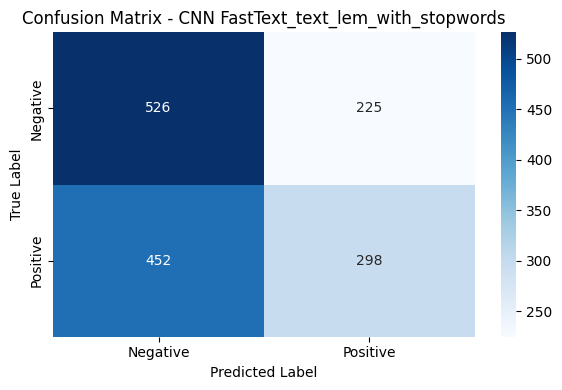

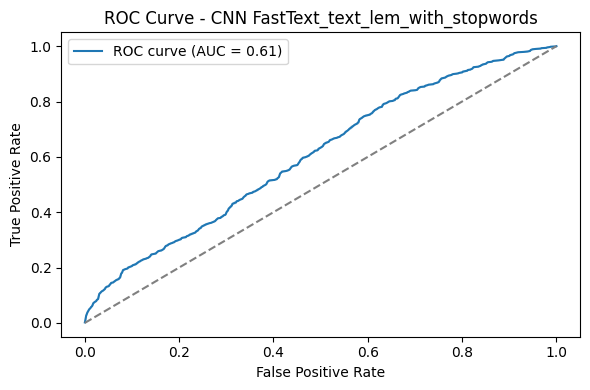

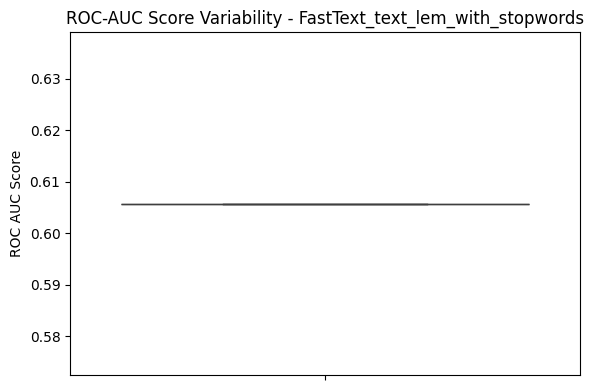


Training CNN model with Word2Vec_text_lem_no_stopwords...



2025/04/18 23:27:31 INFO mlflow.tracking.fluent: Experiment with name 'CNN_Word2Vec_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 11s 90ms/step - loss: 0.7041 - accuracy: 0.5124 - val_loss: 0.6922 - val_accuracy: 0.5307
Epoch 2/10
110/110 [==============================] - 9s 83ms/step - loss: 0.6898 - accuracy: 0.5311 - val_loss: 0.6856 - val_accuracy: 0.5540
Epoch 3/10
110/110 [==============================] - 10s 87ms/step - loss: 0.6851 - accuracy: 0.5484 - val_loss: 0.6817 - val_accuracy: 0.5687
Epoch 4/10
110/110 [==============================] - 9s 84ms/step - loss: 0.6681 - accuracy: 0.5847 - val_loss: 0.6760 - val_accuracy: 0.5853
Epoch 5/10
110/110 [==============================] - 9s 86ms/step - loss: 0.6464 - accuracy: 0.6151 - val_loss: 0.6686 - val_accuracy: 0.5907
Epoch 6/10
110/110 [==============================] - 9s 84ms/step - loss: 0.6213 - accuracy: 0.6488 - val_loss: 0.6657 - val_accuracy: 0.6033
Epoch 7/10
110/110 [==============================] - 9s 84ms/step - loss: 0.5828 - accuracy: 0.6905 - val_loss: 0.6761 - val_accuracy: 0.60

2025/04/18 23:29:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpolpidl4o\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpolpidl4o\model\data\model\assets
2025/04/18 23:29:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


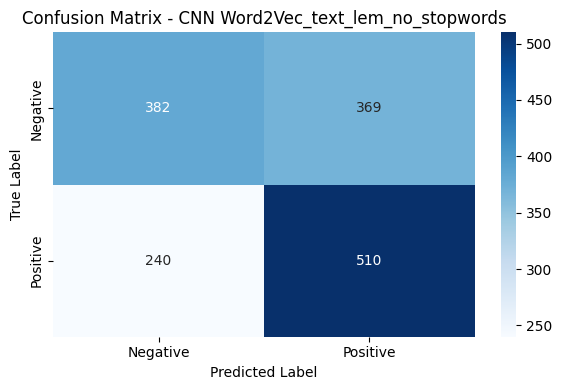

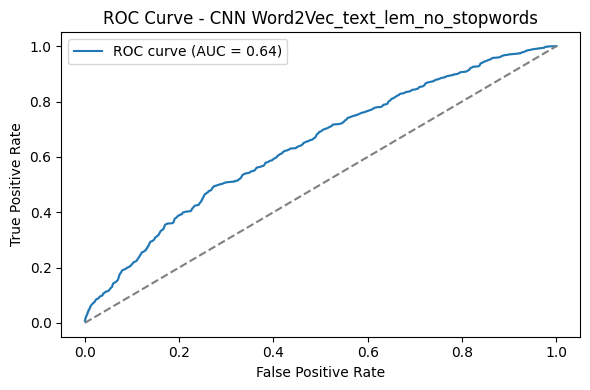

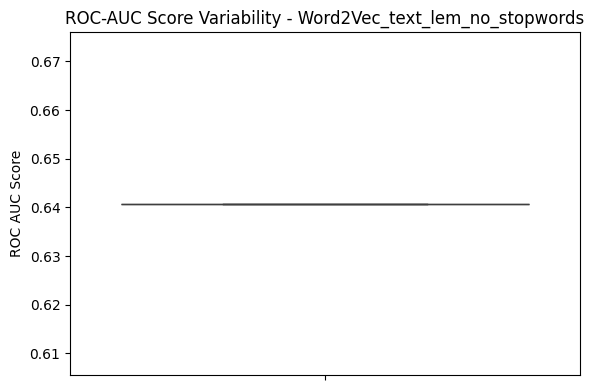


Training CNN model with FastText_text_lem_no_stopwords...



2025/04/18 23:29:22 INFO mlflow.tracking.fluent: Experiment with name 'CNN_FastText_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 10s 85ms/step - loss: 0.7010 - accuracy: 0.5205 - val_loss: 0.6911 - val_accuracy: 0.5300
Epoch 2/10
110/110 [==============================] - 9s 83ms/step - loss: 0.6896 - accuracy: 0.5332 - val_loss: 0.6841 - val_accuracy: 0.5473
Epoch 3/10
110/110 [==============================] - 9s 83ms/step - loss: 0.6831 - accuracy: 0.5425 - val_loss: 0.6806 - val_accuracy: 0.5567
Epoch 4/10
110/110 [==============================] - 9s 84ms/step - loss: 0.6711 - accuracy: 0.5805 - val_loss: 0.6752 - val_accuracy: 0.5800
Epoch 5/10
110/110 [==============================] - 9s 83ms/step - loss: 0.6564 - accuracy: 0.6079 - val_loss: 0.6654 - val_accuracy: 0.5927
Epoch 6/10
110/110 [==============================] - 9s 84ms/step - loss: 0.6324 - accuracy: 0.6347 - val_loss: 0.6602 - val_accuracy: 0.6087
Epoch 7/10
110/110 [==============================] - 9s 84ms/step - loss: 0.6071 - accuracy: 0.6605 - val_loss: 0.6608 - val_accuracy: 0.608

2025/04/18 23:30:55 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpx3z28s4c\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpx3z28s4c\model\data\model\assets
2025/04/18 23:31:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


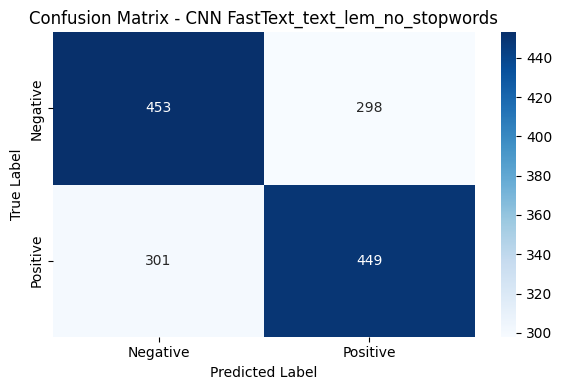

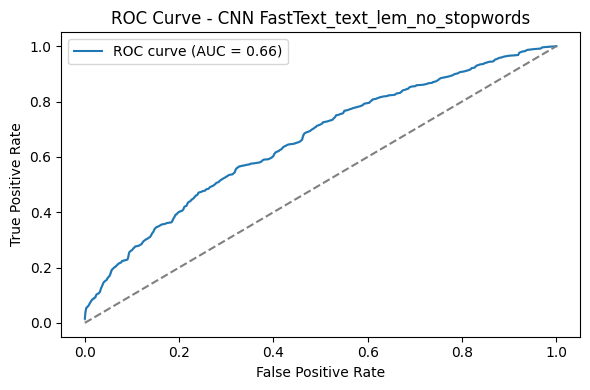

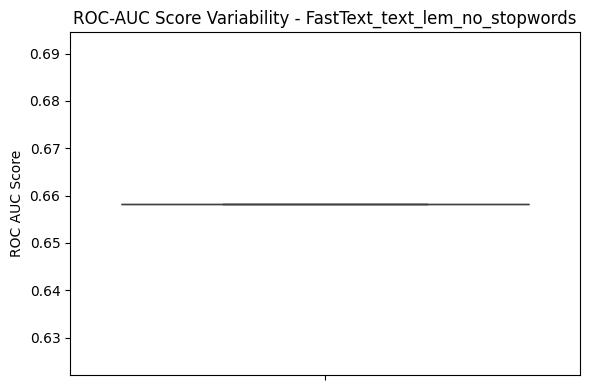


Training CNN model with Word2Vec_text_stem_with_stopwords...



2025/04/18 23:31:11 INFO mlflow.tracking.fluent: Experiment with name 'CNN_Word2Vec_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 9s 56ms/step - loss: 0.7167 - accuracy: 0.5184 - val_loss: 0.6910 - val_accuracy: 0.5360
Epoch 2/10
110/110 [==============================] - 6s 54ms/step - loss: 0.6876 - accuracy: 0.5345 - val_loss: 0.6900 - val_accuracy: 0.5433
Epoch 3/10
110/110 [==============================] - 6s 56ms/step - loss: 0.6786 - accuracy: 0.5601 - val_loss: 0.6850 - val_accuracy: 0.5640
Epoch 4/10
110/110 [==============================] - 6s 55ms/step - loss: 0.6666 - accuracy: 0.5818 - val_loss: 0.6848 - val_accuracy: 0.5507
Epoch 5/10
110/110 [==============================] - 6s 54ms/step - loss: 0.6471 - accuracy: 0.6111 - val_loss: 0.6818 - val_accuracy: 0.5773
Epoch 6/10
110/110 [==============================] - 6s 56ms/step - loss: 0.6239 - accuracy: 0.6397 - val_loss: 0.6742 - val_accuracy: 0.6140
Epoch 7/10
110/110 [==============================] - 6s 55ms/step - loss: 0.5899 - accuracy: 0.6734 - val_loss: 0.6885 - val_accuracy: 0.5873

2025/04/18 23:32:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp7pqz2exa\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp7pqz2exa\model\data\model\assets
2025/04/18 23:32:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


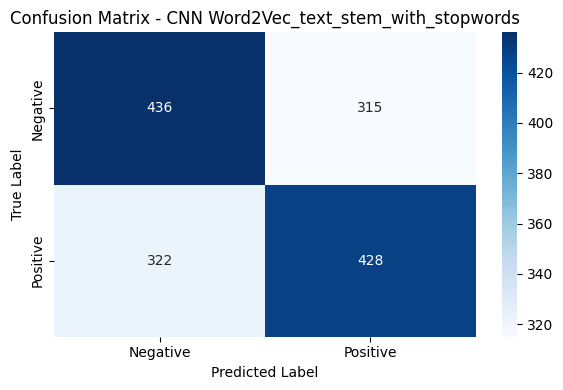

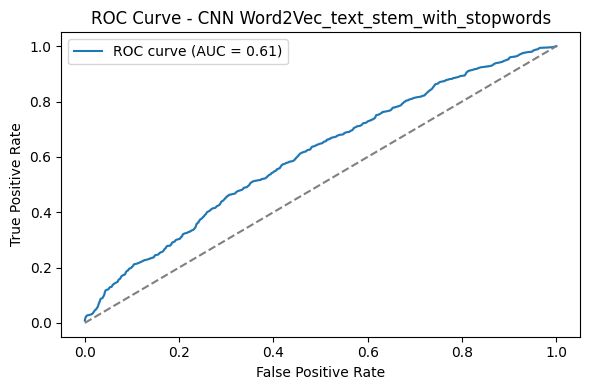

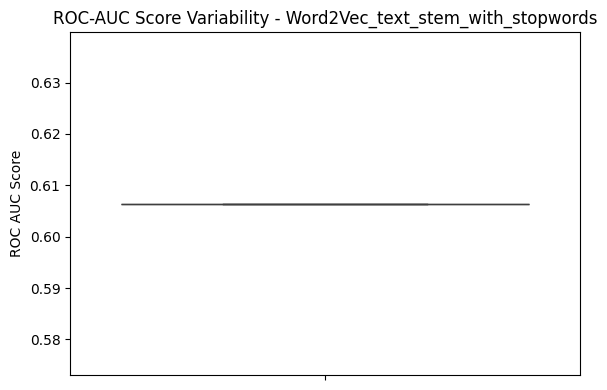


Training CNN model with FastText_text_stem_with_stopwords...



2025/04/18 23:32:31 INFO mlflow.tracking.fluent: Experiment with name 'CNN_FastText_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 6s 52ms/step - loss: 0.7128 - accuracy: 0.5065 - val_loss: 0.6895 - val_accuracy: 0.5073
Epoch 2/10
110/110 [==============================] - 6s 51ms/step - loss: 0.6893 - accuracy: 0.5331 - val_loss: 0.6877 - val_accuracy: 0.5060
Epoch 3/10
110/110 [==============================] - 6s 51ms/step - loss: 0.6838 - accuracy: 0.5505 - val_loss: 0.6840 - val_accuracy: 0.5500
Epoch 4/10
110/110 [==============================] - 6s 52ms/step - loss: 0.6750 - accuracy: 0.5691 - val_loss: 0.6820 - val_accuracy: 0.5660
Epoch 5/10
110/110 [==============================] - 6s 53ms/step - loss: 0.6624 - accuracy: 0.5902 - val_loss: 0.6809 - val_accuracy: 0.5627
Epoch 6/10
110/110 [==============================] - 6s 51ms/step - loss: 0.6441 - accuracy: 0.6187 - val_loss: 0.6813 - val_accuracy: 0.5653
Epoch 7/10
110/110 [==============================] - 6s 51ms/step - loss: 0.6186 - accuracy: 0.6451 - val_loss: 0.6845 - val_accuracy: 0.5827

2025/04/18 23:33:30 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpri300bya\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpri300bya\model\data\model\assets
2025/04/18 23:33:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


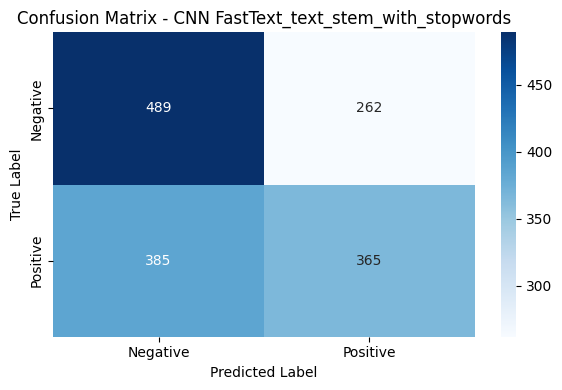

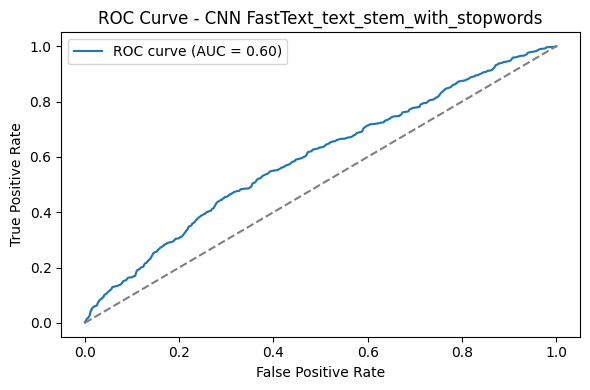

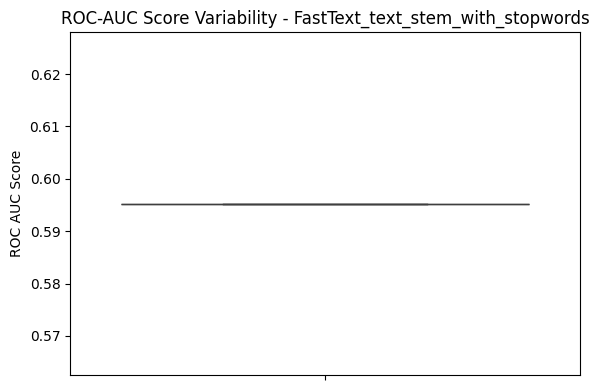


Training CNN model with Word2Vec_text_stem_no_stopwords...



2025/04/18 23:33:45 INFO mlflow.tracking.fluent: Experiment with name 'CNN_Word2Vec_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 6s 49ms/step - loss: 0.7057 - accuracy: 0.5071 - val_loss: 0.6917 - val_accuracy: 0.5253
Epoch 2/10
110/110 [==============================] - 5s 49ms/step - loss: 0.6916 - accuracy: 0.5201 - val_loss: 0.6908 - val_accuracy: 0.5267
Epoch 3/10
110/110 [==============================] - 6s 50ms/step - loss: 0.6850 - accuracy: 0.5428 - val_loss: 0.6851 - val_accuracy: 0.5447
Epoch 4/10
110/110 [==============================] - 5s 49ms/step - loss: 0.6733 - accuracy: 0.5764 - val_loss: 0.6796 - val_accuracy: 0.5640
Epoch 5/10
110/110 [==============================] - 5s 50ms/step - loss: 0.6547 - accuracy: 0.6055 - val_loss: 0.6749 - val_accuracy: 0.5907
Epoch 6/10
110/110 [==============================] - 5s 49ms/step - loss: 0.6333 - accuracy: 0.6379 - val_loss: 0.6893 - val_accuracy: 0.5773
Epoch 7/10
110/110 [==============================] - 5s 48ms/step - loss: 0.6120 - accuracy: 0.6578 - val_loss: 0.6917 - val_accuracy: 0.5740

2025/04/18 23:34:41 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpltlrpfbs\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpltlrpfbs\model\data\model\assets
2025/04/18 23:34:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


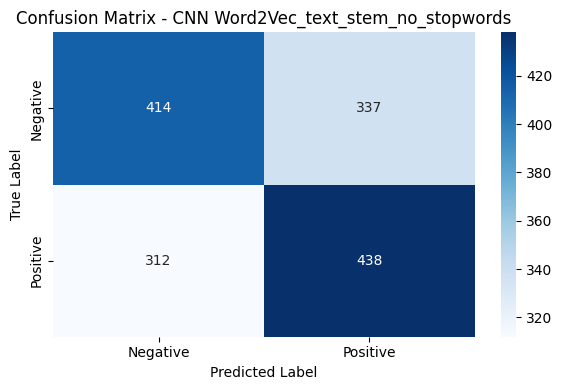

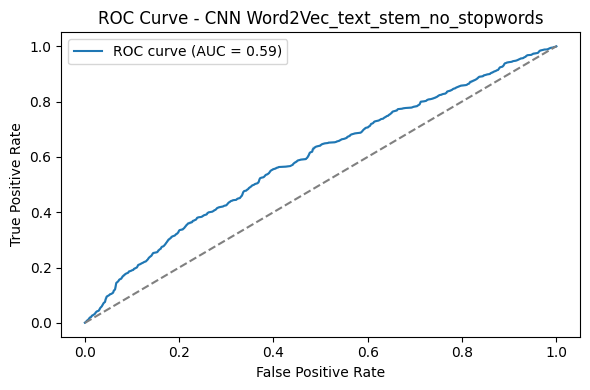

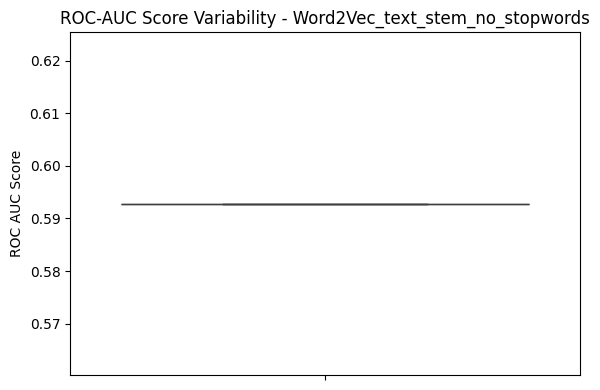


Training CNN model with FastText_text_stem_no_stopwords...



2025/04/18 23:34:57 INFO mlflow.tracking.fluent: Experiment with name 'CNN_FastText_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 6s 48ms/step - loss: 0.6986 - accuracy: 0.4992 - val_loss: 0.6928 - val_accuracy: 0.5273
Epoch 2/10
110/110 [==============================] - 5s 48ms/step - loss: 0.6927 - accuracy: 0.5128 - val_loss: 0.6921 - val_accuracy: 0.5267
Epoch 3/10
110/110 [==============================] - 5s 47ms/step - loss: 0.6921 - accuracy: 0.5158 - val_loss: 0.6928 - val_accuracy: 0.5220
Epoch 4/10
110/110 [==============================] - 5s 46ms/step - loss: 0.6913 - accuracy: 0.5178 - val_loss: 0.6909 - val_accuracy: 0.5400
Epoch 5/10
110/110 [==============================] - 5s 47ms/step - loss: 0.6877 - accuracy: 0.5286 - val_loss: 0.6890 - val_accuracy: 0.5200
Epoch 6/10
110/110 [==============================] - 5s 48ms/step - loss: 0.6852 - accuracy: 0.5422 - val_loss: 0.6841 - val_accuracy: 0.5587
Epoch 7/10
110/110 [==============================] - 5s 46ms/step - loss: 0.6762 - accuracy: 0.5508 - val_loss: 0.6767 - val_accuracy: 0.5693

2025/04/18 23:35:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpp2nag3_h\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpp2nag3_h\model\data\model\assets
2025/04/18 23:35:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


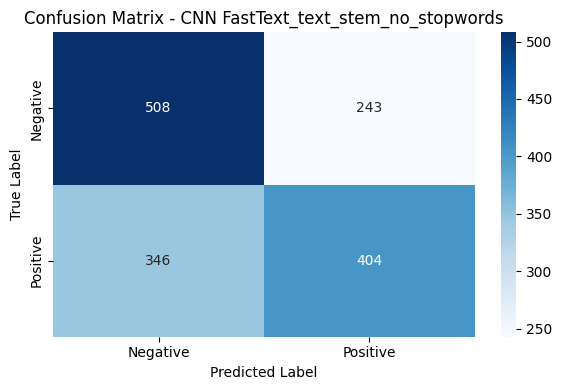

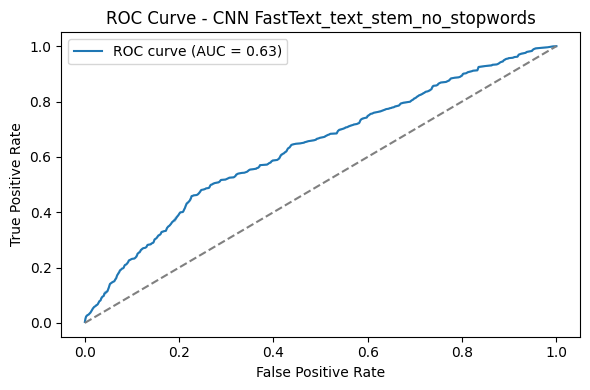

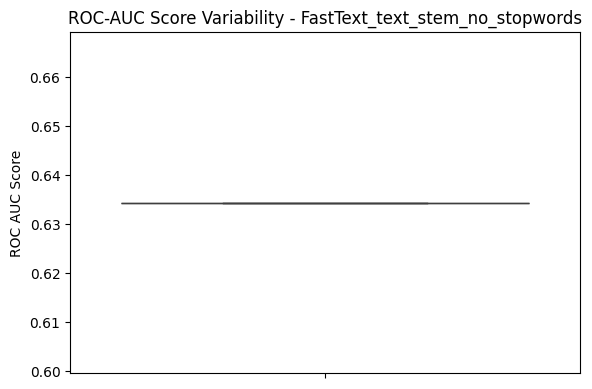

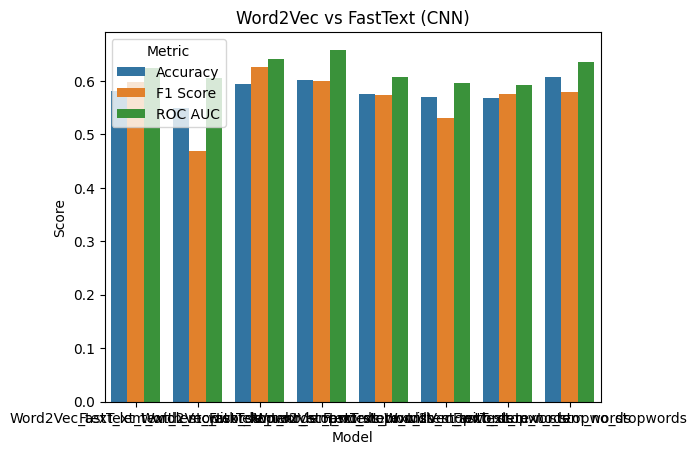

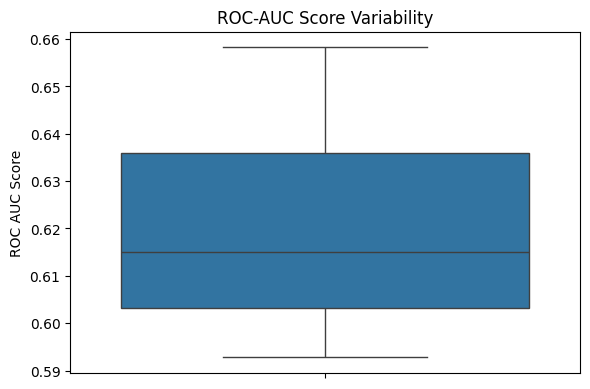

In [13]:
# Hyperparameters
model_scores = []

# Build CNN model

def build_cnn_model(embedding_matrix):
    """Build a CNN model using the provided embedding matrix."""
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False
        ),
        SpatialDropout1D(0.3),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model

# Train and evaluate CNN models
for embedding_name in embedding_models.keys():
    print(f"\nTraining CNN model with {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]

    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)

    model = build_cnn_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"CNN_{embedding_name}")
    with mlflow.start_run(run_name=f"CNN_{embedding_name}"):

        history = model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
        )

        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        loss = log_loss(y_test, y_pred_prob)
        baseline_acc = y_test.value_counts(normalize=True).max()
        confidence_std = np.std(y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        false_positives = cm[0][1]
        false_negatives = cm[1][0]

        # Log to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("log_loss", loss)
        mlflow.log_metric("baseline_accuracy", baseline_acc)
        mlflow.log_metric("confidence_std", confidence_std)
        mlflow.log_metric("false_positives", false_positives)
        mlflow.log_metric("false_negatives", false_negatives)

        mlflow.keras.log_model(model, f"cnn_{embedding_name}_model")

        errors_df = X_test.copy()
        errors_df["true_label"] = y_test.values
        errors_df["predicted_label"] = y_pred
        errors_df["predicted_proba"] = y_pred_prob
        errors_df = errors_df[errors_df["true_label"] != errors_df["predicted_label"]]
        error_filename = f"errors_{embedding_name}.csv"
        errors_df.to_csv(error_filename, index=False)
        mlflow.log_artifact(error_filename, artifact_path="errors")

        for i, row in errors_df.head(3).iterrows():
            mlflow.set_tag(f"error_{i}_text", row["text"])
            mlflow.set_tag(f"error_{i}_true", row["true_label"])
            mlflow.set_tag(f"error_{i}_pred", row["predicted_label"])

        plot_confusion_matrix(y_test, y_pred, f"CNN {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"CNN {embedding_name}")
        plot_boxplot([roc_auc], f"ROC-AUC Score Variability - {embedding_name}")

        model_scores.append((embedding_name, accuracy, f1, roc_auc))

mlflow.end_run()

# Comparison visuals
plot_bar_chart(model_scores, "Word2Vec vs FastText (CNN)")
roc_auc_values = [score[3] for score in model_scores]
plot_boxplot(roc_auc_values, "ROC-AUC Score Variability")


# Adding LSTM to CNN


In [14]:
# Hyperparameters
model_scores = []

def build_cnn_lstm_model(embedding_matrix):
    """
    Build a CNN + LSTM model using a given embedding matrix.
    The model combines convolutional layers for local feature extraction and LSTM for sequential modeling.

    Parameters:
        embedding_matrix (np.array): Pretrained embedding matrix for initializing the embedding layer.

    Returns:
        keras.Sequential: Compiled CNN + LSTM model.
    """
    model = Sequential([
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=EMBEDDING_DIM,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=False
        ),
        SpatialDropout1D(0.3),
        Conv1D(filters=128, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model




Training CNN + LSTM model with Word2Vec_text_lem_with_stopwords...



2025/04/18 23:36:08 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_Word2Vec_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 47s 365ms/step - loss: 0.6990 - accuracy: 0.5124 - val_loss: 0.6916 - val_accuracy: 0.5200
Epoch 2/10
110/110 [==============================] - 39s 356ms/step - loss: 0.6940 - accuracy: 0.5264 - val_loss: 0.6903 - val_accuracy: 0.5393
Epoch 3/10
110/110 [==============================] - 39s 352ms/step - loss: 0.6937 - accuracy: 0.5139 - val_loss: 0.6890 - val_accuracy: 0.5347
Epoch 4/10
110/110 [==============================] - 39s 355ms/step - loss: 0.6919 - accuracy: 0.5184 - val_loss: 0.6862 - val_accuracy: 0.5587
Epoch 5/10
110/110 [==============================] - 39s 355ms/step - loss: 0.6899 - accuracy: 0.5304 - val_loss: 0.6798 - val_accuracy: 0.5587
Epoch 6/10
110/110 [==============================] - 39s 353ms/step - loss: 0.6849 - accuracy: 0.5479 - val_loss: 0.6745 - val_accuracy: 0.5773
Epoch 7/10
110/110 [==============================] - 39s 356ms/step - loss: 0.6816 - accuracy: 0.5464 - val_loss: 0.6720 - val_ac

2025/04/18 23:42:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_zf7rnkc\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_zf7rnkc\model\data\model\assets
2025/04/18 23:43:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


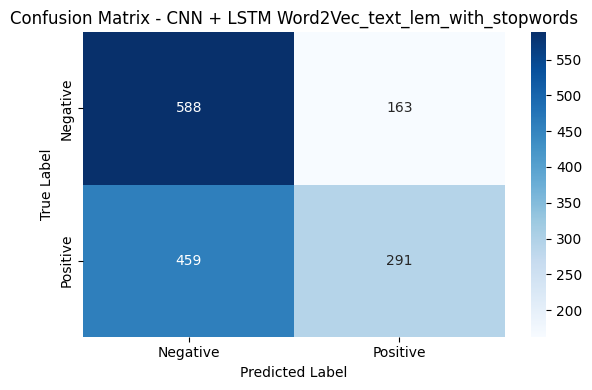

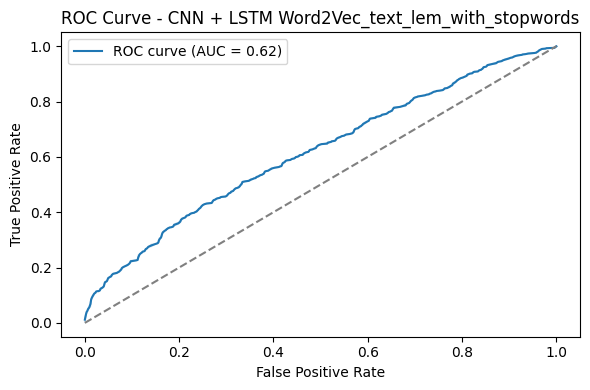

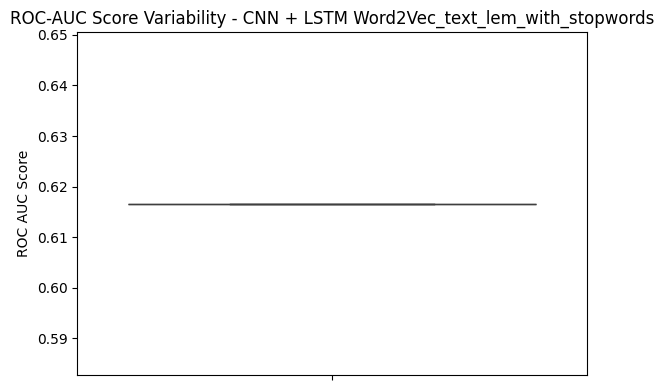


Training CNN + LSTM model with FastText_text_lem_with_stopwords...



2025/04/18 23:43:38 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_FastText_text_lem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 81s 681ms/step - loss: 0.7020 - accuracy: 0.5005 - val_loss: 0.6909 - val_accuracy: 0.5300
Epoch 2/10
110/110 [==============================] - 73s 665ms/step - loss: 0.6959 - accuracy: 0.5079 - val_loss: 0.6893 - val_accuracy: 0.5407
Epoch 3/10
110/110 [==============================] - 74s 674ms/step - loss: 0.6942 - accuracy: 0.5156 - val_loss: 0.6894 - val_accuracy: 0.5387
Epoch 4/10
110/110 [==============================] - 73s 664ms/step - loss: 0.6900 - accuracy: 0.5351 - val_loss: 0.6868 - val_accuracy: 0.5440
Epoch 5/10
110/110 [==============================] - 73s 664ms/step - loss: 0.6881 - accuracy: 0.5408 - val_loss: 0.6797 - val_accuracy: 0.5760
Epoch 6/10
110/110 [==============================] - 73s 665ms/step - loss: 0.6852 - accuracy: 0.5504 - val_loss: 0.6768 - val_accuracy: 0.5547
Epoch 7/10
110/110 [==============================] - 73s 664ms/step - loss: 0.6809 - accuracy: 0.5629 - val_loss: 0.6779 - val_ac

2025/04/18 23:56:05 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpfnbf38sx\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpfnbf38sx\model\data\model\assets
2025/04/18 23:56:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


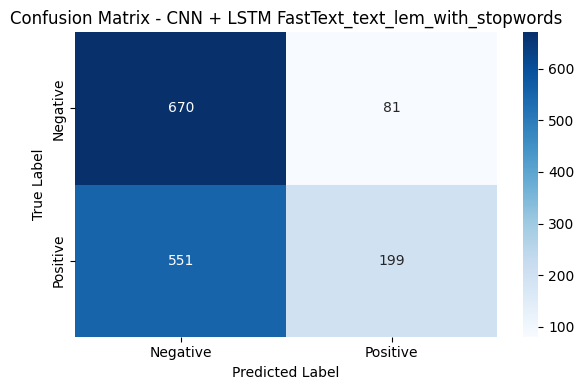

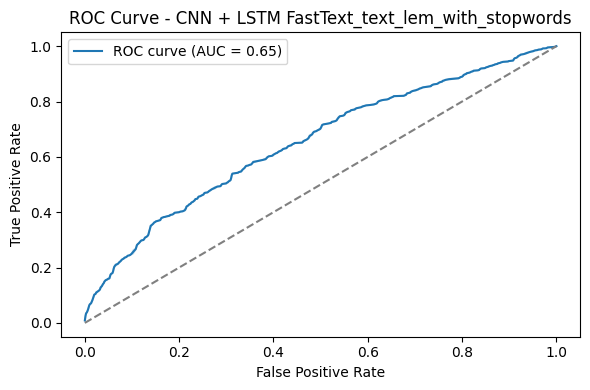

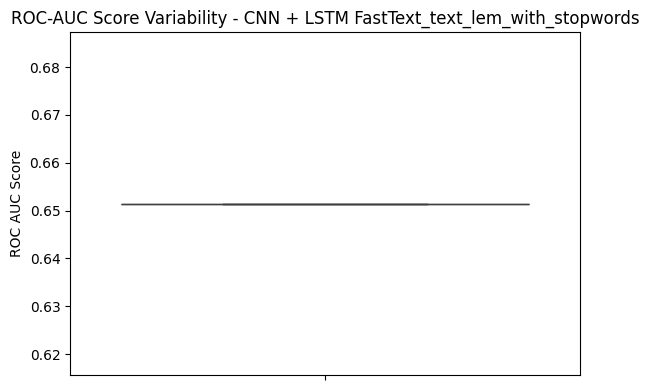


Training CNN + LSTM model with Word2Vec_text_lem_no_stopwords...



2025/04/18 23:56:53 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_Word2Vec_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 88s 743ms/step - loss: 0.6988 - accuracy: 0.4979 - val_loss: 0.6928 - val_accuracy: 0.5187
Epoch 2/10
110/110 [==============================] - 83s 754ms/step - loss: 0.6948 - accuracy: 0.5059 - val_loss: 0.6919 - val_accuracy: 0.5247
Epoch 3/10
110/110 [==============================] - 88s 801ms/step - loss: 0.6948 - accuracy: 0.5094 - val_loss: 0.6913 - val_accuracy: 0.5307
Epoch 4/10
110/110 [==============================] - 88s 797ms/step - loss: 0.6945 - accuracy: 0.5121 - val_loss: 0.6896 - val_accuracy: 0.5493
Epoch 5/10
110/110 [==============================] - 87s 794ms/step - loss: 0.6915 - accuracy: 0.5239 - val_loss: 0.6891 - val_accuracy: 0.5360
Epoch 6/10
110/110 [==============================] - 86s 783ms/step - loss: 0.6893 - accuracy: 0.5374 - val_loss: 0.6866 - val_accuracy: 0.5540
Epoch 7/10
110/110 [==============================] - 86s 780ms/step - loss: 0.6865 - accuracy: 0.5512 - val_loss: 0.6772 - val_ac

2025/04/19 00:11:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpwh4n4vag\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpwh4n4vag\model\data\model\assets
2025/04/19 00:12:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


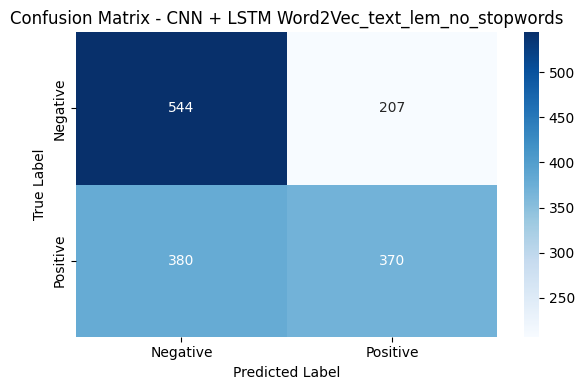

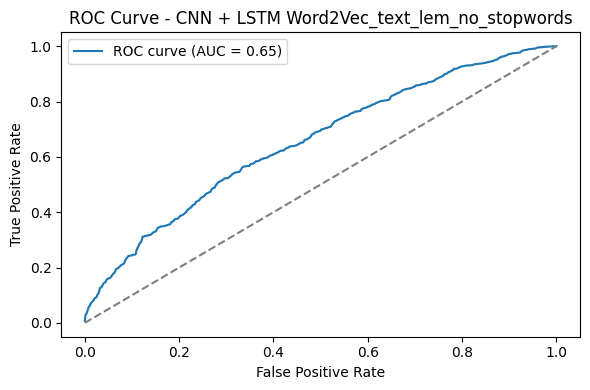

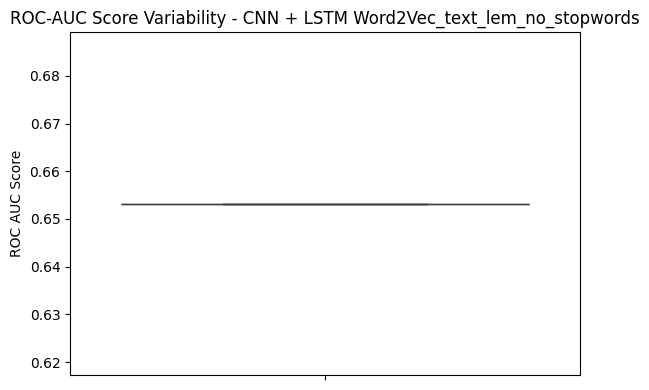


Training CNN + LSTM model with FastText_text_lem_no_stopwords...



2025/04/19 00:12:16 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_FastText_text_lem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 101s 853ms/step - loss: 0.7010 - accuracy: 0.4914 - val_loss: 0.6918 - val_accuracy: 0.5260
Epoch 2/10
110/110 [==============================] - 93s 845ms/step - loss: 0.6959 - accuracy: 0.5014 - val_loss: 0.6929 - val_accuracy: 0.4987
Epoch 3/10
110/110 [==============================] - 93s 849ms/step - loss: 0.6933 - accuracy: 0.5188 - val_loss: 0.6926 - val_accuracy: 0.5300
Epoch 4/10
110/110 [==============================] - 92s 840ms/step - loss: 0.6949 - accuracy: 0.5048 - val_loss: 0.6925 - val_accuracy: 0.5373
Epoch 5/10
110/110 [==============================] - 92s 841ms/step - loss: 0.6928 - accuracy: 0.5132 - val_loss: 0.6922 - val_accuracy: 0.5353
Epoch 6/10
110/110 [==============================] - 93s 845ms/step - loss: 0.6937 - accuracy: 0.5016 - val_loss: 0.6926 - val_accuracy: 0.5300
Epoch 7/10
110/110 [==============================] - 93s 845ms/step - loss: 0.6928 - accuracy: 0.5188 - val_loss: 0.6927 - val_a

2025/04/19 00:28:03 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzb26fe_7\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzb26fe_7\model\data\model\assets
2025/04/19 00:28:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


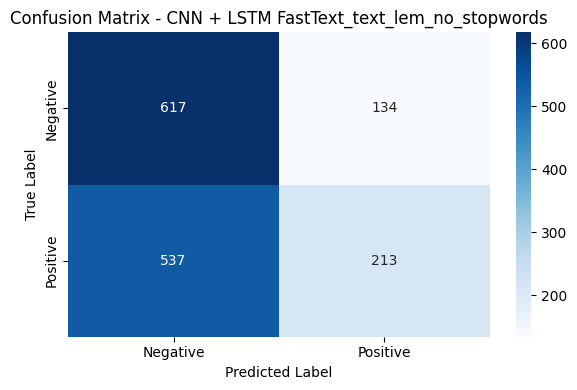

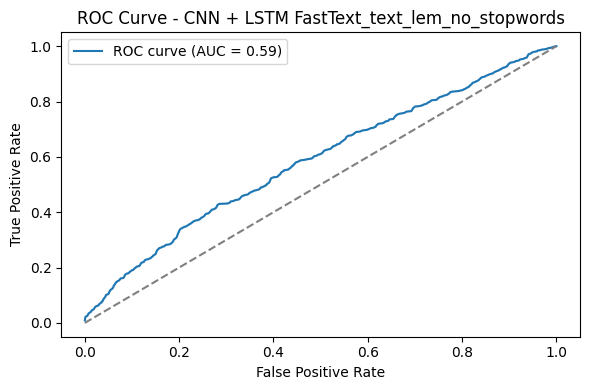

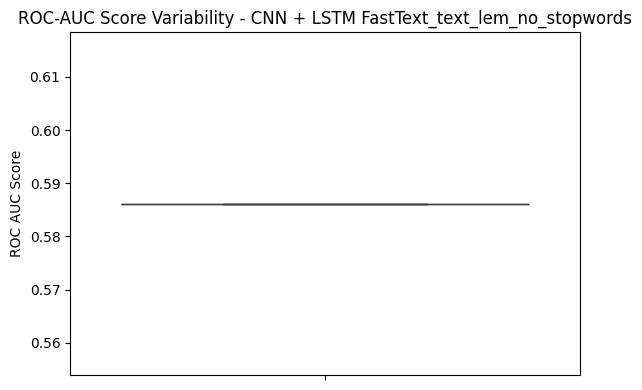


Training CNN + LSTM model with Word2Vec_text_stem_with_stopwords...



2025/04/19 00:28:54 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_Word2Vec_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 79s 654ms/step - loss: 0.7003 - accuracy: 0.5054 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 71s 642ms/step - loss: 0.6946 - accuracy: 0.5065 - val_loss: 0.6917 - val_accuracy: 0.5307
Epoch 3/10
110/110 [==============================] - 71s 644ms/step - loss: 0.6939 - accuracy: 0.5121 - val_loss: 0.6896 - val_accuracy: 0.5367
Epoch 4/10
110/110 [==============================] - 72s 656ms/step - loss: 0.6911 - accuracy: 0.5246 - val_loss: 0.6864 - val_accuracy: 0.5427
Epoch 5/10
110/110 [==============================] - 65s 588ms/step - loss: 0.6895 - accuracy: 0.5382 - val_loss: 0.6804 - val_accuracy: 0.5613
Epoch 6/10
110/110 [==============================] - 65s 590ms/step - loss: 0.6876 - accuracy: 0.5509 - val_loss: 0.6792 - val_accuracy: 0.5640
Epoch 7/10
110/110 [==============================] - 65s 587ms/step - loss: 0.6827 - accuracy: 0.5505 - val_loss: 0.6736 - val_ac

2025/04/19 00:40:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp79ur7qdh\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp79ur7qdh\model\data\model\assets
2025/04/19 00:41:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


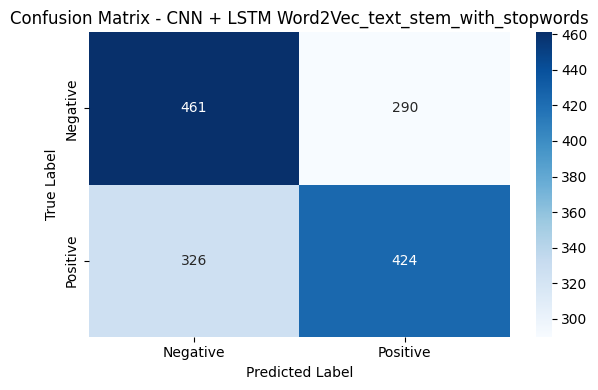

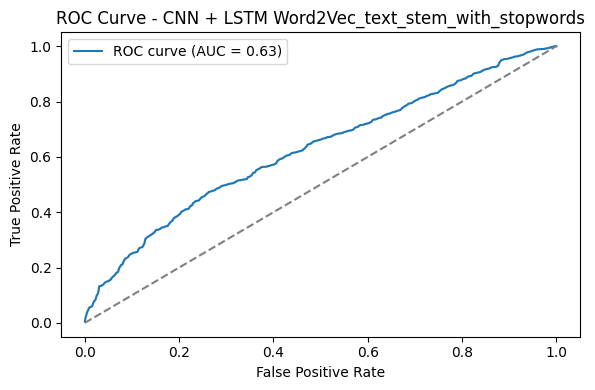

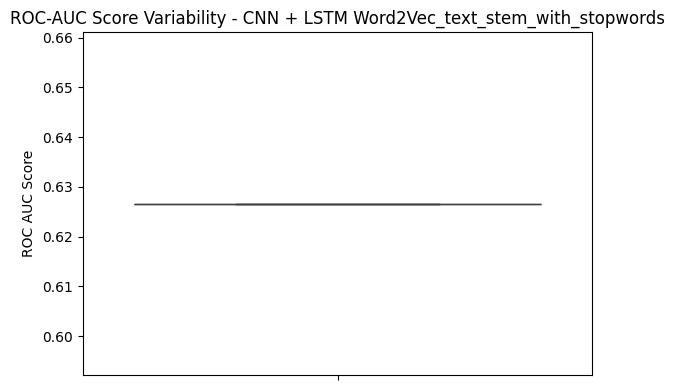


Training CNN + LSTM model with FastText_text_stem_with_stopwords...



2025/04/19 00:41:08 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_FastText_text_stem_with_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 103s 886ms/step - loss: 0.6993 - accuracy: 0.5011 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 95s 866ms/step - loss: 0.6942 - accuracy: 0.5134 - val_loss: 0.6923 - val_accuracy: 0.5147
Epoch 3/10
110/110 [==============================] - 95s 860ms/step - loss: 0.6942 - accuracy: 0.5184 - val_loss: 0.6918 - val_accuracy: 0.5080
Epoch 4/10
110/110 [==============================] - 94s 857ms/step - loss: 0.6917 - accuracy: 0.5299 - val_loss: 0.6894 - val_accuracy: 0.5080
Epoch 5/10
110/110 [==============================] - 94s 853ms/step - loss: 0.6893 - accuracy: 0.5362 - val_loss: 0.6851 - val_accuracy: 0.5200
Epoch 6/10
110/110 [==============================] - 94s 854ms/step - loss: 0.6868 - accuracy: 0.5429 - val_loss: 0.6792 - val_accuracy: 0.5440
Epoch 7/10
110/110 [==============================] - 94s 852ms/step - loss: 0.6827 - accuracy: 0.5564 - val_loss: 0.6723 - val_a

2025/04/19 00:56:51 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp95lvys6j\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp95lvys6j\model\data\model\assets
2025/04/19 00:57:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


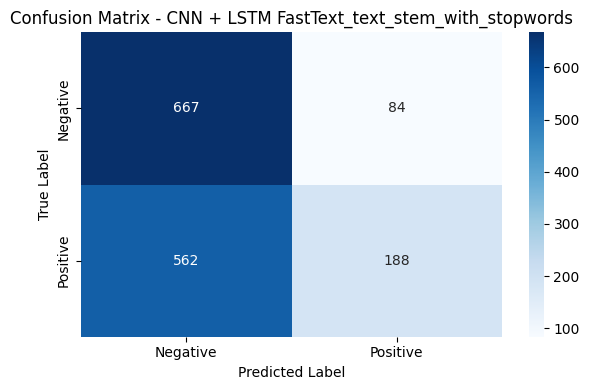

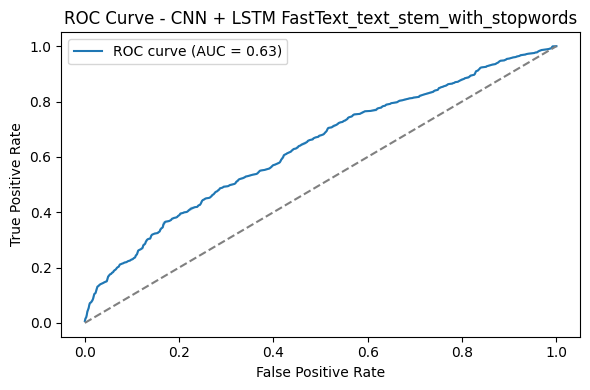

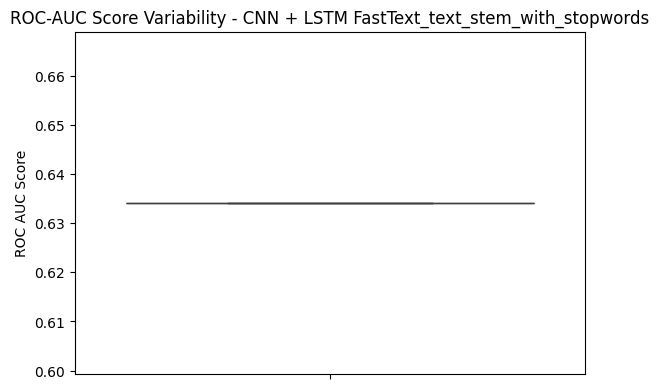


Training CNN + LSTM model with Word2Vec_text_stem_no_stopwords...



2025/04/19 00:57:32 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_Word2Vec_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 73s 591ms/step - loss: 0.7006 - accuracy: 0.5076 - val_loss: 0.6936 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 63s 571ms/step - loss: 0.6954 - accuracy: 0.5061 - val_loss: 0.6925 - val_accuracy: 0.5307
Epoch 3/10
110/110 [==============================] - 63s 577ms/step - loss: 0.6955 - accuracy: 0.5069 - val_loss: 0.6929 - val_accuracy: 0.4993
Epoch 4/10
110/110 [==============================] - 62s 567ms/step - loss: 0.6944 - accuracy: 0.5086 - val_loss: 0.6919 - val_accuracy: 0.5273
Epoch 5/10
110/110 [==============================] - 64s 578ms/step - loss: 0.6934 - accuracy: 0.5098 - val_loss: 0.6920 - val_accuracy: 0.5280
Epoch 6/10
110/110 [==============================] - 63s 575ms/step - loss: 0.6949 - accuracy: 0.5049 - val_loss: 0.6918 - val_accuracy: 0.5293
Epoch 7/10
110/110 [==============================] - 63s 570ms/step - loss: 0.6938 - accuracy: 0.5141 - val_loss: 0.6924 - val_ac

2025/04/19 01:08:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzuher9t4\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmpzuher9t4\model\data\model\assets
2025/04/19 01:08:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


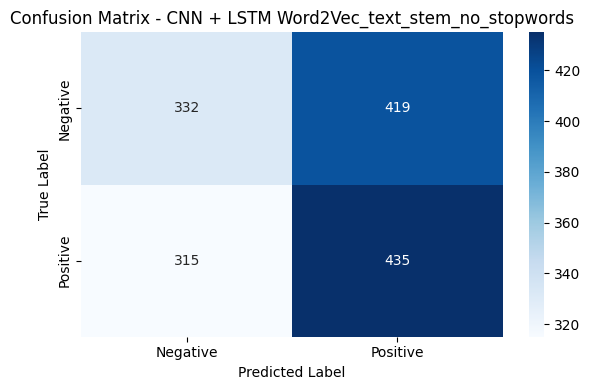

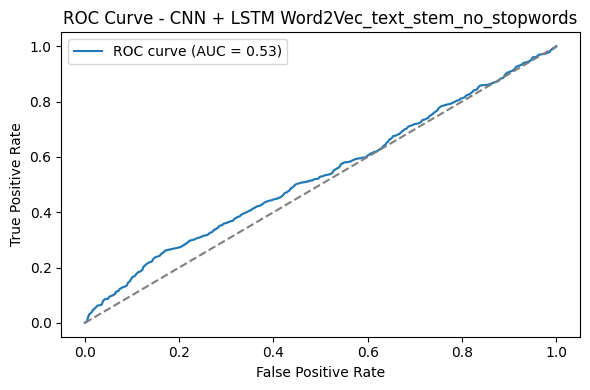

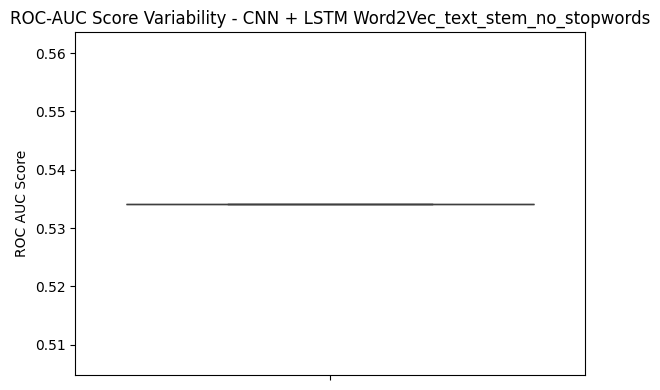


Training CNN + LSTM model with FastText_text_stem_no_stopwords...



2025/04/19 01:09:02 INFO mlflow.tracking.fluent: Experiment with name 'CNN_LSTM_FastText_text_stem_no_stopwords' does not exist. Creating a new experiment.


Epoch 1/10
110/110 [==============================] - 107s 924ms/step - loss: 0.6979 - accuracy: 0.4922 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/10
110/110 [==============================] - 99s 899ms/step - loss: 0.6950 - accuracy: 0.5024 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 3/10
110/110 [==============================] - 100s 906ms/step - loss: 0.6937 - accuracy: 0.5136 - val_loss: 0.6934 - val_accuracy: 0.5100
Epoch 4/10
110/110 [==============================] - 100s 908ms/step - loss: 0.6942 - accuracy: 0.5074 - val_loss: 0.6924 - val_accuracy: 0.5287
Epoch 5/10
110/110 [==============================] - 100s 907ms/step - loss: 0.6933 - accuracy: 0.5074 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
110/110 [==============================] - 100s 913ms/step - loss: 0.6941 - accuracy: 0.5091 - val_loss: 0.6925 - val_accuracy: 0.5247
Epoch 7/10
110/110 [==============================] - 100s 910ms/step - loss: 0.6930 - accuracy: 0.5085 - val_loss: 0.6924 - 

2025/04/19 01:26:09 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_uzdebye\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\misss\AppData\Local\Temp\tmp_uzdebye\model\data\model\assets
2025/04/19 01:26:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


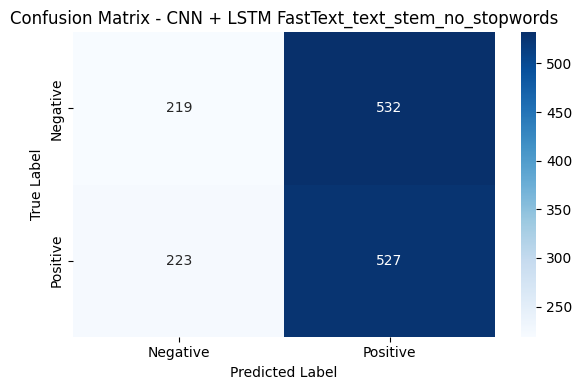

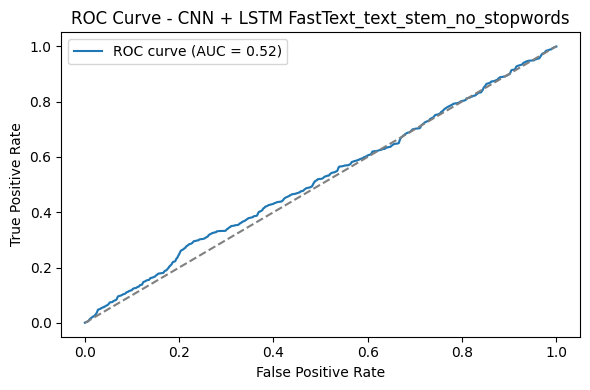

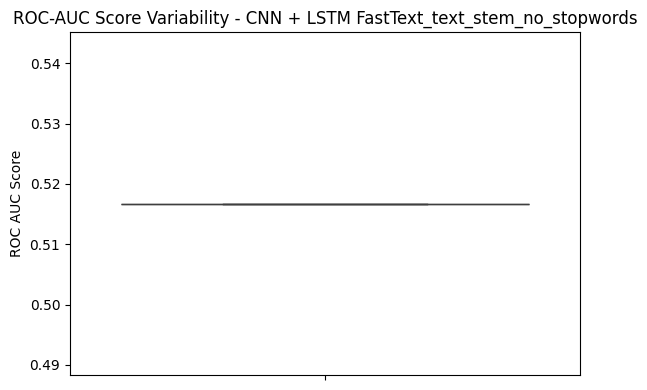

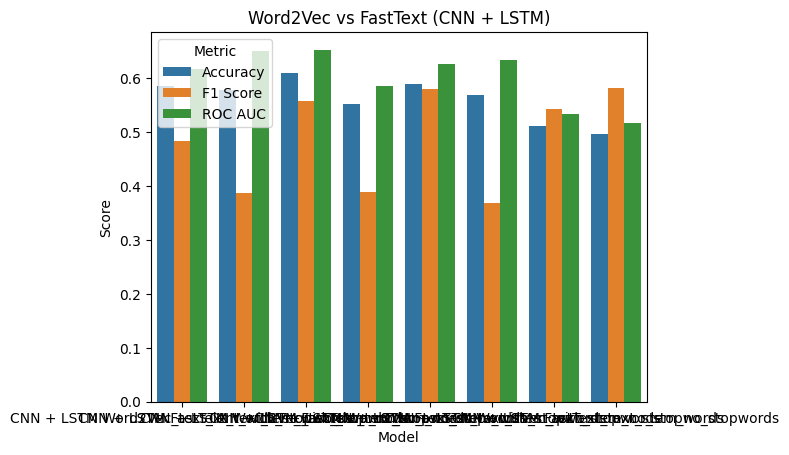

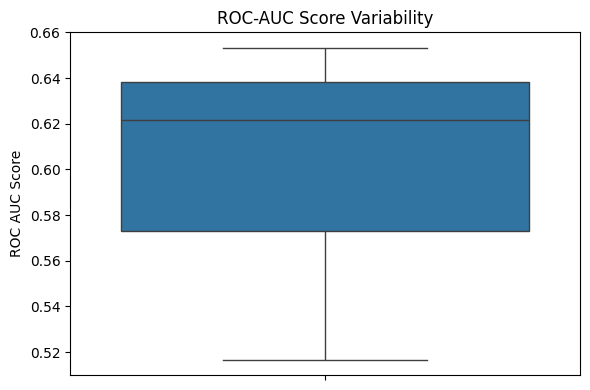

In [15]:
# Train and evaluate CNN + LSTM models
for embedding_name in embedding_models.keys():
    print(f"\nTraining CNN + LSTM model with {embedding_name}...\n")
    text_col = embedding_name.split("_", 1)[1]

    # Convert token sequences
    X_train_seq = tokens_to_sequences(X_train[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_val_seq = tokens_to_sequences(X_val[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)
    X_test_seq = tokens_to_sequences(X_test[text_col], word_indices[embedding_name], MAX_SEQUENCE_LENGTH)

    model = build_cnn_lstm_model(embedding_matrices[embedding_name])

    mlflow.set_experiment(f"CNN_LSTM_{embedding_name}")
    with mlflow.start_run(run_name=f"CNN_LSTM_{embedding_name}"):

        # Train the model
        model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            verbose=1
        )

        # Predictions
        y_pred_prob = model.predict(X_test_seq).flatten()
        y_pred = (y_pred_prob >= 0.5).astype(int)

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        loss = log_loss(y_test, y_pred_prob)
        baseline_acc = y_test.value_counts(normalize=True).max()
        confidence_std = np.std(y_pred_prob)
        cm = confusion_matrix(y_test, y_pred)
        false_positives = cm[0][1]
        false_negatives = cm[1][0]

        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("roc_auc", roc_auc)
        mlflow.log_metric("log_loss", loss)
        mlflow.log_metric("baseline_accuracy", baseline_acc)
        mlflow.log_metric("confidence_std", confidence_std)
        mlflow.log_metric("false_positives", false_positives)
        mlflow.log_metric("false_negatives", false_negatives)

        # Log model
        mlflow.keras.log_model(model, f"cnn_lstm_{embedding_name}_model")

        # Save incorrect predictions
        errors_df = X_test.copy()
        errors_df["true_label"] = y_test.values
        errors_df["predicted_label"] = y_pred
        errors_df["predicted_proba"] = y_pred_prob
        errors_df = errors_df[errors_df["true_label"] != errors_df["predicted_label"]]
        error_filename = f"errors_cnn_lstm_{embedding_name}.csv"
        errors_df.to_csv(error_filename, index=False)
        mlflow.log_artifact(error_filename, artifact_path="errors")

        for i, row in errors_df.head(3).iterrows():
            mlflow.set_tag(f"error_{i}_text", row["text"])
            mlflow.set_tag(f"error_{i}_true", row["true_label"])
            mlflow.set_tag(f"error_{i}_pred", row["predicted_label"])

        # Visualizations
        plot_confusion_matrix(y_test, y_pred, f"CNN + LSTM {embedding_name}")
        plot_roc_curve(y_test, y_pred_prob, f"CNN + LSTM {embedding_name}")
        plot_boxplot([roc_auc], f"ROC-AUC Score Variability - CNN + LSTM {embedding_name}")

        # Append model score for final comparison
        model_scores.append((f"CNN + LSTM {embedding_name}", accuracy, f1, roc_auc))

mlflow.end_run()

# Final comparison visualizations
plot_bar_chart(model_scores, "Word2Vec vs FastText (CNN + LSTM)")
roc_auc_values = [score[3] for score in model_scores]
plot_boxplot(roc_auc_values, "ROC-AUC Score Variability")

# Modèle Transformer (BERT)

In [16]:
# Hyperparameters
model_scores = []

# Configuration
model_name = "distilbert-base-uncased"
batch_size = 32
epochs = 3
learning_rate = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Add <OOV> token if it does not exist
if "<OOV>" not in tokenizer.get_vocab():
    tokenizer.add_tokens(["<OOV>"])

# Load model and resize embeddings
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)
model.resize_token_embeddings(len(tokenizer))

# Custom PyTorch dataset for tokenized text
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

# Prepare datasets
train_dataset = TextDataset(X_train["text_bert"].tolist(), y_train.tolist())
val_dataset = TextDataset(X_val["text_bert"].tolist(), y_val.tolist())
test_dataset = TextDataset(X_test["text_bert"].tolist(), y_test.tolist())

# Prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


2025/04/19 01:27:05 INFO mlflow.tracking.fluent: Experiment with name 'DISTILBERT_MODEL' does not exist. Creating a new experiment.
Epoch 1/3: 100%|██████████| 219/219 [36:25<00:00,  9.98s/it]


Epoch 1 completed - Average loss: 0.5019


Epoch 2/3: 100%|██████████| 219/219 [35:10<00:00,  9.64s/it]


Epoch 2 completed - Average loss: 0.3231


Epoch 3/3: 100%|██████████| 219/219 [34:34<00:00,  9.47s/it]


Epoch 3 completed - Average loss: 0.1519


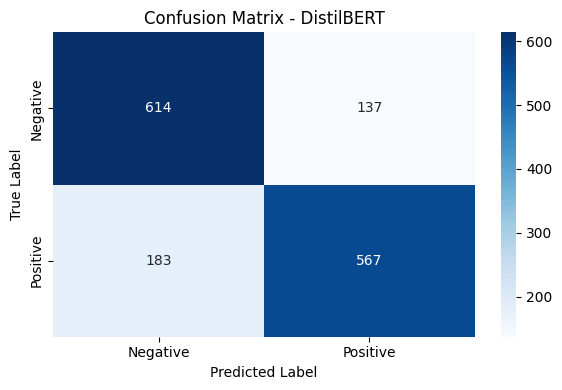

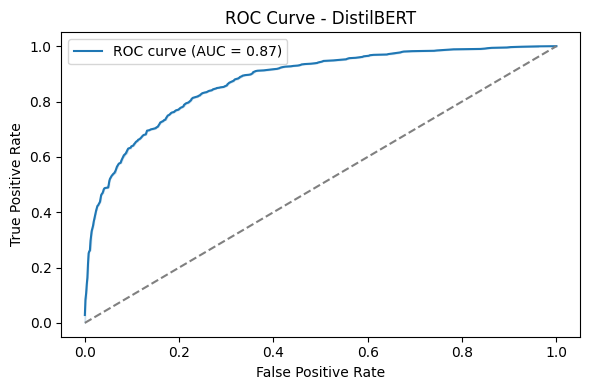

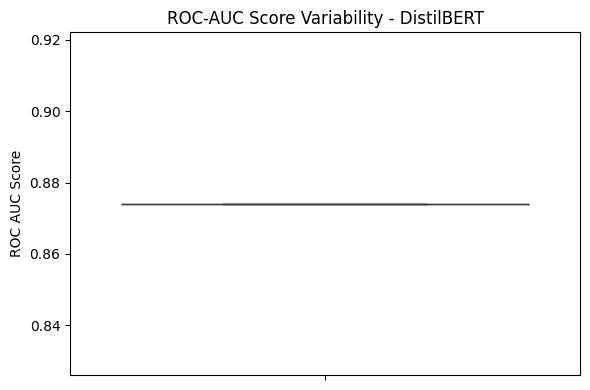

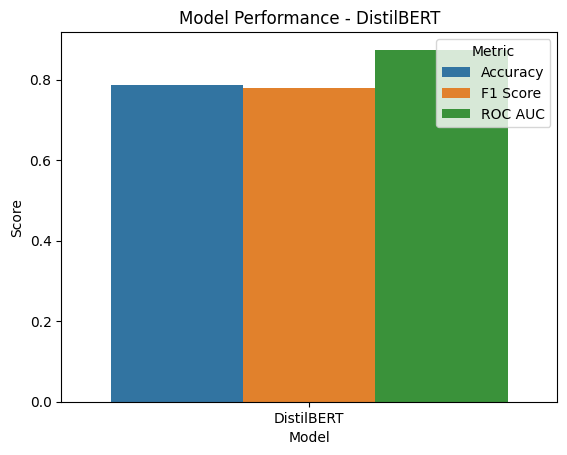

In [17]:
# Training and MLflow logging
mlflow.set_experiment("DISTILBERT_MODEL")

with mlflow.start_run():
    mlflow.log_params({
        "model": model_name,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs
    })

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1} completed - Average loss: {avg_loss:.4f}")
        mlflow.log_metric(f"train_loss_epoch_{epoch + 1}", avg_loss)

    # Evaluation
    model.eval()
    all_preds, all_probs, all_labels = [], [], []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()

            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    loss = log_loss(all_labels, all_probs)
    baseline_acc = np.max(np.bincount(all_labels) / len(all_labels))
    confidence_std = np.std(all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    false_positives = cm[0][1]
    false_negatives = cm[1][0]

    mlflow.log_metrics({
        "accuracy": accuracy,
        "f1_score": f1,
        "precision": precision,
        "recall": recall,
        "roc_auc": roc_auc,
        "log_loss": loss,
        "baseline_accuracy": baseline_acc,
        "confidence_std": confidence_std,
        "false_positives": false_positives,
        "false_negatives": false_negatives
    })

    # Save and log model
    torch.save(model.state_dict(), "DISTILBERT_MODEL.pt")
    mlflow.log_artifact("DISTILBERT_MODEL.pt")

    # Save incorrect predictions
    errors_df = pd.DataFrame({
        "text": X_test["text"].tolist(),
        "true_label": all_labels,
        "predicted_label": all_preds,
        "predicted_proba": all_probs
    })
    errors_df = errors_df[errors_df["true_label"] != errors_df["predicted_label"]]
    errors_df.to_csv("errors_distilbert.csv", index=False)
    mlflow.log_artifact("errors_distilbert.csv", artifact_path="errors")

    for i, row in errors_df.head(3).iterrows():
        mlflow.set_tag(f"error_{i}_text", row["text"])
        mlflow.set_tag(f"error_{i}_true", row["true_label"])
        mlflow.set_tag(f"error_{i}_pred", row["predicted_label"])

    # Visualizations
    plot_confusion_matrix(all_labels, all_preds, "DistilBERT")
    plot_roc_curve(all_labels, all_probs, "DistilBERT")
    plot_boxplot([roc_auc], "ROC-AUC Score Variability - DistilBERT")
    plot_bar_chart([
        ("DistilBERT", accuracy, f1, roc_auc)
    ], "Model Performance - DistilBERT")

